In [1]:
## Important Options:
run_epochs = 200
run_model_type = "full_y_CVAE"

run_save_folder = "../../outputs/experiments_test/syntheticshapes/cvae/" 
run_read_data_folder = "../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/" # 1 2 3
trust_set_name = "50_samples_per_class" # 5; 10; 25, 50;


In [2]:
ls ../../outputs

experiments_test/


In [3]:
%run ../repair_syserr_models/main.py \
    --cuda-on \
    --save-on \
    --output-folder {run_save_folder} \
    --verbose-metrics-epoch \
    --model-type {run_model_type} \
    --number-epochs {run_epochs} \
    --dataset-folder {run_read_data_folder} \
    --use-binary-img \
    --kl-anneal \
    --kl-anneal-start 0.0 \
    --kl-anneal-stop 1.0 \
    --kl-anneal-ratio 0.5 \
    --kl-anneal-delay-epochs 10 \
    --fixed-prior-zy1-sigma 0.5 \
    --use-q-z-y \
    --trust-set-name {trust_set_name}


Namespace(activation='relu', batch_size=128, cuda_on=True, data_folder='../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/', dist_corr_reg=False, dist_corr_reg_coeff=1.0, embedding_size=50, fixed_prior_z_clean=1.0, fixed_prior_z_dirty=5.0, fixed_prior_zy0_sigma=5.0, fixed_prior_zy1_sigma=0.5, kl_anneal=True, kl_anneal_cycles=1, kl_anneal_delay_epochs=10, kl_anneal_ratio=0.5, kl_anneal_start=0.0, kl_anneal_stop=1.0, kl_beta_const=1.0, l2_reg=0.0, latent_dim=15, layer_size=400, learn_z_given_y_priors=False, load_model=False, load_model_path=None, log_interval=50, lr=0.001, mean_eps_z_in=0.0, model_type='full_y_CVAE', number_epochs=200, output_folder='../../outputs/experiments_test/syntheticshapes/cvae/', q_y_x_coeff=1.0, qy_sup_weights=None, reg_delay_n_epochs=5, reg_schedule_ratio=0.5, save_on=True, semi_supervise=False, sigma_eps_z_in=0.1, size_input=784, size_output=784, sup_loss_coeff=0.1, train_on_clean_data=False, trust_set_name='50_samples_per_class', use_batch_n

### Define Paths

In [4]:
# Data folder
file_path_data = run_read_data_folder + "train/"

# Experiment / results folder
model_type = run_model_type
file_path_exper = run_save_folder + model_type + "/"

In [5]:
# Check folder of dataset
!ls {file_path_data}/..

cols_info.json	full  noising_info.json  test  train  validation


In [6]:
with open(file_path_data + "y_noise_dict.json") as json_file:
    y_noise_dict_train = json.load(json_file)
    
#trusted_idxs_train = pd.read_csv(file_path_data + "trusted_idxs.csv").values.flatten()
trusted_idxs_train = pd.read_csv(file_path_data + f"/trusted_idxs_{trust_set_name}.csv").values.flatten()

In [7]:
ls "../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/train/"

cells_changed_mtx.csv                  trusted_idxs_25_samples_per_class.csv
changes_summary.csv                    trusted_idxs_50_samples_per_class.csv
data_clean.csv                         trusted_idxs_5_samples_per_class.csv
data_noised.csv                        tuples_changed_mtx.csv
original_idxs.csv                      y_class.csv
trusted_idxs_10_samples_per_class.csv  y_noise_dict.json


### Check VARS on Notebook

In [8]:
whos

Variable               Type             Data/Info
-------------------------------------------------
StandardTrainer        type             <class 'repair_syserr_mod<...>r_utils.StandardTrainer'>
args                   Namespace        Namespace(activation='rel<...>False, y_clean_prior=0.7)
compute_metrics        function         <function compute_metrics at 0x7f17543a4ca0>
dict_main_vars         dict             n=53
errno                  module           <module 'errno' (built-in)>
evaluation_phase       function         <function evaluation_phase at 0x7f160ab7c8b0>
file_path_data         str              ../../data/examples_synth<...>l_35_percent/run_1/train/
file_path_exper        str              ../../outputs/experiments<...>cshapes/cvae/full_y_CVAE/
frange_cycle_linear    function         <function frange_cycle_linear at 0x7f160d29ae50>
gen_utils              module           <module 'repair_syserr_mo<...>err_models/gen_utils.py'>
json                   module           <module

In [9]:
# debug vars -- from main.py
dict_main_vars.keys()

dict_keys(['args', 'train_loader', 'X_train', 'target_errors_train', 'dataset_obj', 'attributes', 'trusted_mask', 'train_loader_no_shuff', 'valid_loader', 'X_valid', 'target_errors_valid', 'dataset_valid_obj', '_', 'valid_loader_no_shuff', 'test_loader', 'X_test', 'target_errors_test', 'dataset_test_obj', 'test_loader_no_shuff', 'train_clean_loader', 'X_train_clean', 'dataset_obj_train_clean', 'train_clean_loader_no_shuff', 'X_valid_clean', 'dataset_obj_valid_clean', 'valid_clean_loader_no_shuff', 'X_test_clean', 'dataset_obj_test_clean', 'test_clean_loader_no_shuff', 'runin_model', 'model', 'train_optim', 'losses_save', 'kl_anneal', 'kl_beta_n_cycles', 'kl_beta_ratio', 'delay_n_epochs', 'delay_beta_vec', '_delay_n_epochs', 'kl_beta_vec', 'reg_schedule_vec', '_train_loader_used', '_train_loader_no_shuff', '_valid_loader_no_shuff', '_test_loader_no_shuff', '_X_train', '_X_valid', '_X_test', 'epoch', 'kl_beta_val', 'reg_schedule_val', 'folder_output', 'outfile'])

### Load Packages 

In [10]:
import pandas as pd
import numpy as np
import torch
import repair_syserr_models.gen_utils as gen_utils
from repair_syserr_models import full_y_CVAE
import json

import pprint
import seaborn as sns
from matplotlib import pyplot as plt
import os
import json

### Check Dataset Definitions and Noising

In [11]:
with open(file_path_data + "../noising_info.json") as f:
    dt_defs = json.load(f)
pprint.pprint(dt_defs)

{'name': 'run_1',
 'synth_data': {'defs': {'combs_on': False,
                         'corrupt_prob': 0.35,
                         'n_samples': 5000,
                         'random_state': None},
                'noise_list_trusted': 'regular',
                'type': 'ShapesWithStrips'},
 'test_size': 0.1,
 'train_size': 0.8,
 'trusted_set': {'dataset_size': 5000,
                 'frac_trusted': None,
                 'mc_mode': 'fixed_number',
                 'min_coverage': True,
                 'n_classes': 8,
                 'percentages': [0.8, 1.6, 4.0, 8.0],
                 'samples_fixed': [5, 10, 25, 50],
                 'total_points': [40, 80, 200, 400],
                 'use_labels': 'joint_classes',
                 'y_class_on': True,
                 'y_noise_lists_on': True},
 'valid_size': 0.1}


In [12]:
with open(file_path_data + "../cols_info.json") as f:
    col_defs = json.load(f)
pprint.pprint(col_defs)

{'cat_cols_names': [],
 'dataset_type': 'image',
 'image_defs': {'channel_type': 'gray',
                'channels': [],
                'num_channels': 1,
                'size': [28, 28]},
 'num_cols_names': ['pixel_0',
                    'pixel_1',
                    'pixel_2',
                    'pixel_3',
                    'pixel_4',
                    'pixel_5',
                    'pixel_6',
                    'pixel_7',
                    'pixel_8',
                    'pixel_9',
                    'pixel_10',
                    'pixel_11',
                    'pixel_12',
                    'pixel_13',
                    'pixel_14',
                    'pixel_15',
                    'pixel_16',
                    'pixel_17',
                    'pixel_18',
                    'pixel_19',
                    'pixel_20',
                    'pixel_21',
                    'pixel_22',
                    'pixel_23',
                    'pixel_24',
                   

### Load Datasets

In [13]:

# train
train_loader, X_train, target_errors_train, dataset_obj, attributes, trusted_mask = gen_utils.load_data(args.data_folder, 
                                                                                                        args.batch_size,
                                                                                                        is_train=True,
                                                                                                        get_data_idxs=True,
                                                                                                        semi_sup_data=True,
                                                                                                        use_binary_img=True,
                                                                                                        trust_set_name=trust_set_name)
    

# Dynamic options for dataset_obj (from args)
dataset_obj.use_binary_img = args.use_binary_img


# test
test_loader, X_test, target_errors_test, _, _ = gen_utils.load_data(args.data_folder, 
                                                                    args.batch_size, 
                                                                    is_train=False,
                                                                    use_binary_img=True)

# -> clean versions for evaluation
_, X_train_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                                args.batch_size,
                                                is_train=True, 
                                                is_clean=True, 
                                                stdize_dirty=True,
                                                use_binary_img=True)

_, X_test_clean, _, _, _ = gen_utils.load_data(args.data_folder, 
                                               args.batch_size, 
                                               is_train=False,
                                               is_clean=True, 
                                               stdize_dirty=True,
                                               use_binary_img=True)


In [14]:
args.data_folder

'../../data/examples_synthetic_shapes/corrupt_level_35_percent/run_1/'

In [15]:
y_noise_instance_train = target_errors_train.any(dim=1).numpy()
y_noise_pixels_train = target_errors_train.numpy().reshape(-1,28,28)

y_targets_mdl = ~ torch.from_numpy(y_noise_instance_train).view(-1,1)

x_train_orig = X_train.view(-1,28,28).numpy()
x_train_clean_orig = X_train_clean.view(-1,28,28).numpy()


In [16]:
X_train_clean.view(-1,28,28)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

### Load Model

In [17]:
vae_mdl = eval(model_type).VAE(dataset_obj, args)
file_path_model = file_path_exper + "model_params.pth"
vae_mdl.load_state_dict(torch.load(file_path_model))
vae_mdl.eval()

VAE(
  (activ): ReLU()
  (var_q_z): encodeMVNDiag(
    (torso_encoder): baseEncoder(
      (activ): ReLU()
      (feat_embedd): ModuleList()
      (mod_fw_seq): Sequential(
        (fc_0): Linear(in_features=785, out_features=200, bias=True)
        (activ_0): ReLU()
        (fc_1): Linear(in_features=200, out_features=100, bias=True)
        (activ_1): ReLU()
        (fc_2): Linear(in_features=100, out_features=50, bias=True)
        (activ_2): ReLU()
      )
    )
    (param_nn): GaussDiagDistModule(
      (mu): modSeq(
        (mods_list): ModuleList(
          (0): baseEncoder(
            (activ): ReLU()
            (feat_embedd): ModuleList()
            (mod_fw_seq): Sequential(
              (fc_0): Linear(in_features=785, out_features=200, bias=True)
              (activ_0): ReLU()
              (fc_1): Linear(in_features=200, out_features=100, bias=True)
              (activ_1): ReLU()
              (fc_2): Linear(in_features=100, out_features=50, bias=True)
              (ac

### Load Results from Folder

In [18]:
file_path_exper

'../../outputs/experiments_test/syntheticshapes/cvae/full_y_CVAE/'

In [19]:
df_train_metrics = pd.read_csv(file_path_exper + "train_epochs_data.csv")
df_valid_metrics = pd.read_csv(file_path_exper + "validation_epochs_data.csv")
df_test_metrics = pd.read_csv(file_path_exper + "test_epochs_data.csv")

In [20]:
!ls {file_path_exper}

args_run.json			train_error_repair_features.csv
model_params.pth		trusted_auc_features.csv
test_auc_features.csv		trusted_avpr_features.csv
test_avpr_features.csv		trusted_epochs_data.csv
test_epochs_data.csv		trusted_error_repair_features.csv
test_error_repair_features.csv	validation_auc_features.csv
train_auc_features.csv		validation_avpr_features.csv
train_avpr_features.csv		validation_epochs_data.csv
train_epochs_data.csv		validation_error_repair_features.csv


In [21]:
df_train_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0         1       283.355394      283.355394            0.0  283.355394   
1         2       274.910750      274.910750            0.0  274.910750   
2         3       260.577284      260.577284            0.0  260.577284   
3         4       220.764323      220.764323            0.0  220.764323   
4         5       196.096452      196.096452            0.0  196.096452   
..      ...              ...             ...            ...         ...   
195     196        26.783963       26.783963            0.0    7.135975   
196     197        25.828559       25.828559            0.0    6.856381   
197     198        29.082037       29.082037            0.0    9.700003   
198     199        26.436183       26.436183            0.0    7.270622   
199     200        26.539049       26.539049            0.0    7.357384   

     Avg. KLD_TOT  Avg. KLD_Z  AUC Cell nll score  AVPR Cell nll score  \
0       86.510099   86.510099            0.830926             0.384609   
1       51.796800   51.796800            0.842715             0.402148   
2      168.903075  168.903075            0.867065             0.452094   
3      278.663016  278.663016            0.910944             0.619239   
4      447.924236  447.924236            0.928784             0.696967   
..            ...         ...                 ...                  ...   
195     19.647988   19.647988            0.747406             0.157438   
196     18.972178   18.972178            0.732618             0.146303   
197     19.382034   19.382034            0.692945             0.140213   
198     19.165562   19.165562            0.701478             0.150255   
199     19.181665   19.181665            0.744880             0.166989   

     AUC Row nll score  AVPR Row nll score  AUC Row class_y score  \
0             0.615891            0.418767                  -10.0   
1             0.652810            0.478156                  -10.0   
2             0.655903            0.495062                  -10.0   
3             0.645070            0.456739                  -10.0   
4             0.689272            0.486761                  -10.0   
..                 ...                 ...                    ...   
195           0.672069            0.496492                  -10.0   
196           0.653655            0.468080                  -10.0   
197           0.639605            0.489076                  -10.0   
198           0.663243            0.489101                  -10.0   
199           0.647116            0.470281                  -10.0   

     AVPR Row class_y score  Error lower-bound on dirty pos  \
0                     -10.0                        0.134310   
1                     -10.0                        0.123735   
2                     -10.0                        0.113653   
3                     -10.0                        0.081760   
4                     -10.0                        0.079852   
..                      ...                             ...   
195                   -10.0                        0.004451   
196                   -10.0                        0.006684   
197                   -10.0                        0.004243   
198                   -10.0                        0.006755   
199                   -10.0                        0.002246   

     Error upper-bound on dirty pos  Error repair on dirty pos  \
0                               1.0                   0.131327   
1                               1.0                   0.124738   
2                               1.0                   0.119682   
3                               1.0                   0.088780   
4                               1.0                   0.091015   
..                              ...                        ...   
195                             1.0                   0.189279   
196                             1.0                   0.204841   
197                             1.0

In [22]:
df_valid_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0         1       284.954344      284.954344            0.0  284.954344   
1         2       276.763148      276.763148            0.0  276.763148   
2         3       262.544711      262.544711            0.0  262.544711   
3         4       222.040328      222.040328            0.0  222.040328   
4         5       196.903328      196.903328            0.0  196.903328   
..      ...              ...             ...            ...         ...   
195     196        29.547678       29.547678            0.0    9.764938   
196     197        28.445371       28.445371            0.0    9.389177   
197     198        31.990928       31.990928            0.0   12.525952   
198     199        29.142333       29.142333            0.0    9.872279   
199     200        29.548978       29.548978            0.0   10.251936   

     Avg. KLD_TOT  Avg. KLD_Z  AUC Cell nll score  AVPR Cell nll score  \
0       84.994400   84.994400            0.830280             0.398929   
1       50.851991   50.851991            0.842582             0.417566   
2      160.613766  160.613766            0.866538             0.464703   
3      262.374895  262.374895            0.910519             0.620403   
4      421.157094  421.157094            0.930548             0.680876   
..            ...         ...                 ...                  ...   
195     19.782741   19.782741            0.753798             0.176064   
196     19.056193   19.056193            0.742009             0.166923   
197     19.464976   19.464976            0.697918             0.163324   
198     19.270054   19.270054            0.714096             0.169403   
199     19.297042   19.297042            0.754649             0.186895   

     AUC Row nll score  AVPR Row nll score  AUC Row class_y score  \
0             0.572923            0.393658                  -10.0   
1             0.617522            0.458230                  -10.0   
2             0.631640            0.475947                  -10.0   
3             0.659483            0.504499                  -10.0   
4             0.692781            0.487957                  -10.0   
..                 ...                 ...                    ...   
195           0.786328            0.611890                  -10.0   
196           0.741266            0.564860                  -10.0   
197           0.734082            0.594188                  -10.0   
198           0.748930            0.568492                  -10.0   
199           0.735098            0.567032                  -10.0   

     AVPR Row class_y score  Error lower-bound on dirty pos  \
0                     -10.0                        0.133826   
1                     -10.0                        0.121985   
2                     -10.0                        0.112341   
3                     -10.0                        0.082482   
4                     -10.0                        0.078261   
..                      ...                             ...   
195                   -10.0                        0.004741   
196                   -10.0                        0.006324   
197                   -10.0                        0.004431   
198                   -10.0                        0.005729   
199                   -10.0                        0.003661   

     Error upper-bound on dirty pos  Error repair on dirty pos  \
0                               1.0                   0.130884   
1                               1.0                   0.123058   
2                               1.0                   0.117912   
3                               1.0                   0.089614   
4                               1.0                   0.090493   
..                              ...                        ...   
195                             1.0                   0.179915   
196                             1.0                   0.193735   
197                             1.0

In [23]:
df_test_metrics

Epochs  Avg. TOTAL_LOSS  Avg. LOSS_ELBO  Avg. LOSS_SUP    Avg. NLL  \
0         1       284.954344      284.954344            0.0  284.954344   
1         2       276.763148      276.763148            0.0  276.763148   
2         3       262.544711      262.544711            0.0  262.544711   
3         4       222.040328      222.040328            0.0  222.040328   
4         5       196.903328      196.903328            0.0  196.903328   
..      ...              ...             ...            ...         ...   
195     196        29.547678       29.547678            0.0    9.764938   
196     197        28.445371       28.445371            0.0    9.389177   
197     198        31.990928       31.990928            0.0   12.525952   
198     199        29.142333       29.142333            0.0    9.872279   
199     200        29.548978       29.548978            0.0   10.251936   

     Avg. KLD_TOT  Avg. KLD_Z  AUC Cell nll score  AVPR Cell nll score  \
0       84.994400   84.994400            0.830280             0.398929   
1       50.851991   50.851991            0.842582             0.417566   
2      160.613766  160.613766            0.866538             0.464703   
3      262.374895  262.374895            0.910519             0.620403   
4      421.157094  421.157094            0.930548             0.680876   
..            ...         ...                 ...                  ...   
195     19.782741   19.782741            0.753798             0.176064   
196     19.056193   19.056193            0.742009             0.166923   
197     19.464976   19.464976            0.697918             0.163324   
198     19.270054   19.270054            0.714096             0.169403   
199     19.297042   19.297042            0.754649             0.186895   

     AUC Row nll score  AVPR Row nll score  AUC Row class_y score  \
0             0.572923            0.393658                  -10.0   
1             0.617522            0.458230                  -10.0   
2             0.631640            0.475947                  -10.0   
3             0.659483            0.504499                  -10.0   
4             0.692781            0.487957                  -10.0   
..                 ...                 ...                    ...   
195           0.786328            0.611890                  -10.0   
196           0.741266            0.564860                  -10.0   
197           0.734082            0.594188                  -10.0   
198           0.748930            0.568492                  -10.0   
199           0.735098            0.567032                  -10.0   

     AVPR Row class_y score  Error lower-bound on dirty pos  \
0                     -10.0                        0.133826   
1                     -10.0                        0.121985   
2                     -10.0                        0.112341   
3                     -10.0                        0.082482   
4                     -10.0                        0.078261   
..                      ...                             ...   
195                   -10.0                        0.004741   
196                   -10.0                        0.006324   
197                   -10.0                        0.004431   
198                   -10.0                        0.005729   
199                   -10.0                        0.003661   

     Error upper-bound on dirty pos  Error repair on dirty pos  \
0                               1.0                   0.130884   
1                               1.0                   0.123058   
2                               1.0                   0.117912   
3                               1.0                   0.089614   
4                               1.0                   0.090493   
..                              ...                        ...   
195                             1.0                   0.179915   
196                             1.0                   0.193735   
197                             1.0

In [24]:
n_epochs = df_train_metrics.shape[0]
epochs_range = list(range(1,n_epochs+1))

### Train Dataset Final Results

In [25]:
# Train final results
df_train_metrics.loc[n_epochs-1,:]

Epochs                                      200.000000
Avg. TOTAL_LOSS                              26.539049
Avg. LOSS_ELBO                               26.539049
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                      7.357384
Avg. KLD_TOT                                 19.181665
Avg. KLD_Z                                   19.181665
AUC Cell nll score                            0.744880
AVPR Cell nll score                           0.166989
AUC Row nll score                             0.647116
AVPR Row nll score                            0.470281
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.002246
Error upper-bound on dirty pos                1.000000
Error repair on dirty pos                     0.195128
Error repair on clean pos                     0.004800
Error repair on clean pos - dirty points      0.010125
Name: 199,

In [26]:
# Validation final results
df_valid_metrics.loc[n_epochs-1,:]

Epochs                                      200.000000
Avg. TOTAL_LOSS                              29.548978
Avg. LOSS_ELBO                               29.548978
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                     10.251936
Avg. KLD_TOT                                 19.297042
Avg. KLD_Z                                   19.297042
AUC Cell nll score                            0.754649
AVPR Cell nll score                           0.186895
AUC Row nll score                             0.735098
AVPR Row nll score                            0.567032
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.003661
Error upper-bound on dirty pos                1.000000
Error repair on dirty pos                     0.185545
Error repair on clean pos                     0.005571
Error repair on clean pos - dirty points      0.011278
Name: 199,

### Test Dataset Final Results

In [27]:
# Train final results
df_test_metrics.loc[n_epochs-1,:]

Epochs                                      200.000000
Avg. TOTAL_LOSS                              29.548978
Avg. LOSS_ELBO                               29.548978
Avg. LOSS_SUP                                 0.000000
Avg. NLL                                     10.251936
Avg. KLD_TOT                                 19.297042
Avg. KLD_Z                                   19.297042
AUC Cell nll score                            0.754649
AVPR Cell nll score                           0.186895
AUC Row nll score                             0.735098
AVPR Row nll score                            0.567032
AUC Row class_y score                       -10.000000
AVPR Row class_y score                      -10.000000
Error lower-bound on dirty pos                0.003661
Error upper-bound on dirty pos                1.000000
Error repair on dirty pos                     0.185545
Error repair on clean pos                     0.005571
Error repair on clean pos - dirty points      0.011278
Name: 199,

## PLOTS TRAIN DATASET

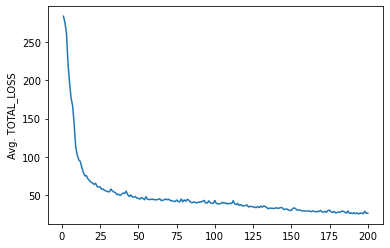

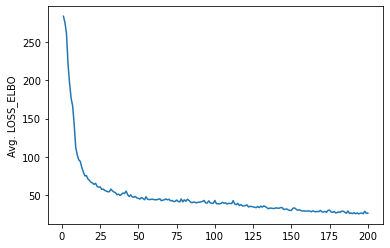

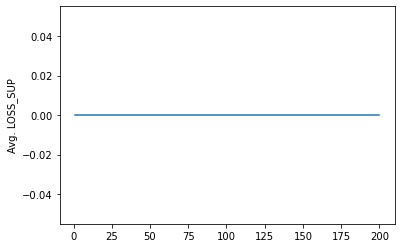

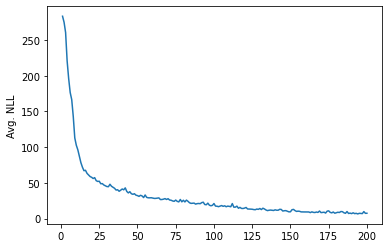

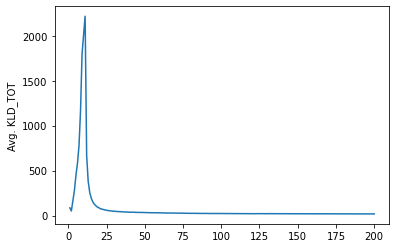

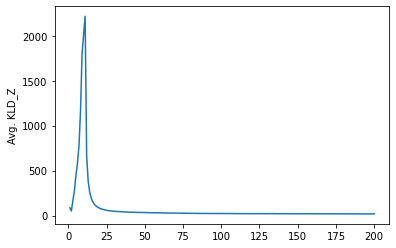

In [28]:
# Plots for losses
for col_name in df_train_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
        plt.show()

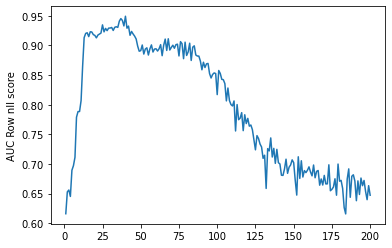

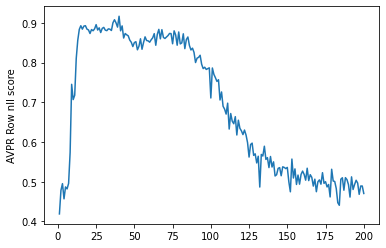

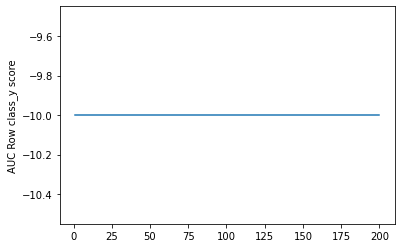

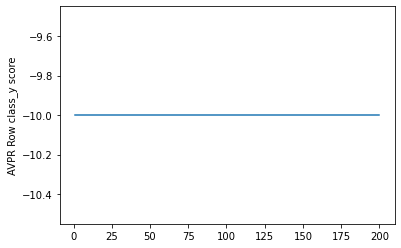

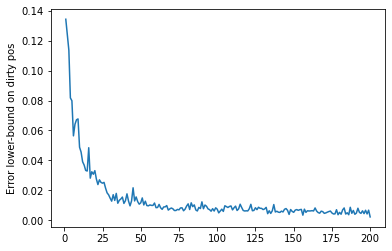

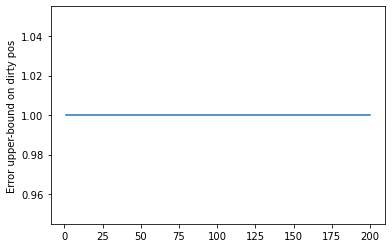

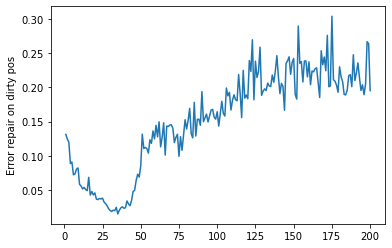

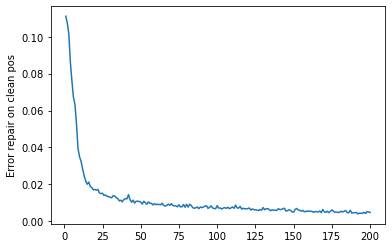

In [29]:
# Plots for classification and repair metrics
list_plot_custom = ["AUC Row nll score", "AVPR Row nll score", 
                    "AUC Row class_y score", "AVPR Row class_y score",
                    "Error lower-bound on dirty pos", "Error upper-bound on dirty pos",
                    "Error repair on dirty pos", "Error repair on clean pos"]

for col_name in list_plot_custom:
    sns.lineplot(x=epochs_range,y=df_train_metrics[col_name])
    plt.show()

### Plot Validation -- Losses

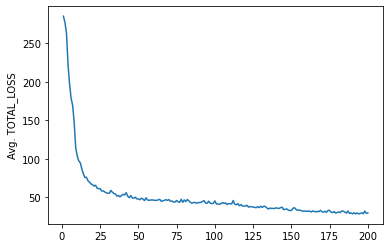

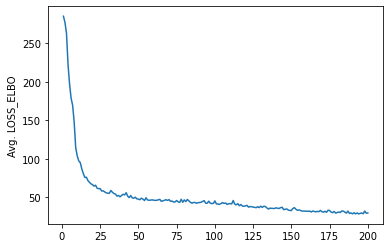

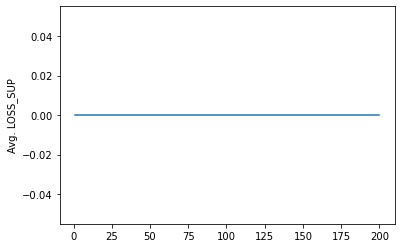

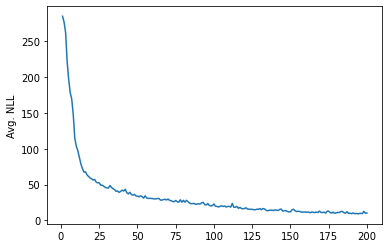

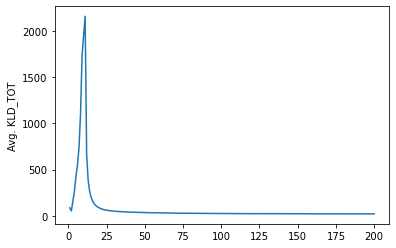

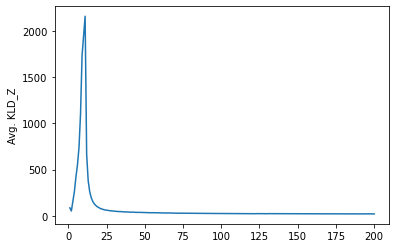

In [30]:
# Plots for losses
for col_name in df_valid_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_valid_metrics[col_name])
        plt.show()

### Plot Test -- Losses

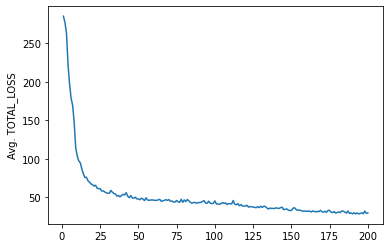

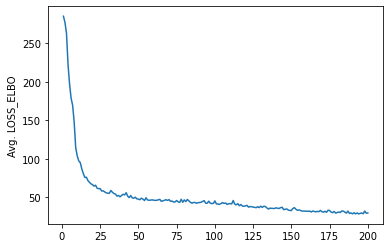

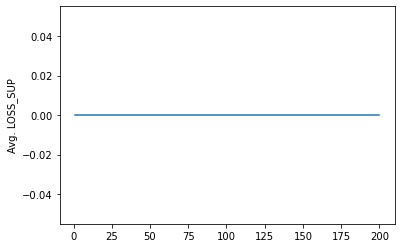

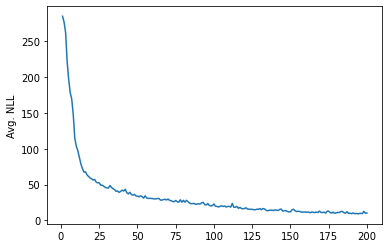

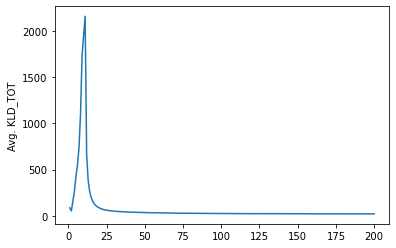

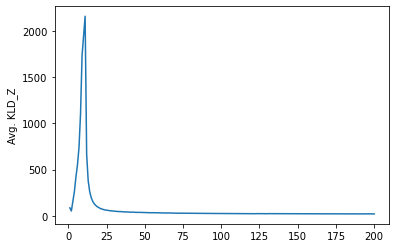

In [31]:
# Plots for losses
for col_name in df_test_metrics.columns:
    if "Avg. " in col_name:
        sns.lineplot(x=epochs_range,y=df_test_metrics[col_name])
        plt.show()

### Get Recons, Latent Space, etc

In [32]:
vae_p_params_xd, vae_q_params, vae_q_samples, _ = vae_mdl(X_train, y_targets=y_targets_mdl, repair_mode=True)
recons_train = vae_p_params_xd['recon']['x'].cpu().detach().numpy()
z_train_clean = vae_q_params['z']['mu'].detach().cpu().numpy()


In [33]:
# Plot mu's and covariance's

z_train_mu = vae_q_params['z']['mu'].detach().cpu().numpy()
z_train_var = np.exp(vae_q_params['z']['logvar'].detach().cpu().numpy())

print("median of variances (per dim), clean: \n {} \n".format(np.median(z_train_var, axis=0)))
print("median of means (per dim), clean: \n {} \n".format(np.median(z_train_mu, axis=0)))


median of variances (per dim), clean: 
 [0.00108732 0.24779755 0.25096792 0.2080622  0.0020863  0.00161793
 0.25043574 0.00215166 0.23783615 0.00099707 0.25245053 0.24981913
 0.25063223 0.0011757  0.00267776] 

median of means (per dim), clean: 
 [ 0.00050241 -0.00548974 -0.00701066  0.01174742  0.02566837 -0.044155
  0.00512222  0.00119933  0.00208472 -0.00422909  0.00371849 -0.00586329
  0.00760719  0.04786962 -0.00868997] 



### Recons

In [34]:
recon_imgs_train = recons_train.reshape(-1,28,28)

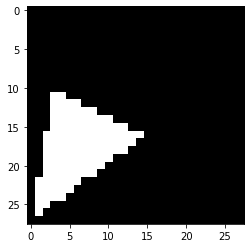

In [35]:
# Show image from train dataset

plt.imshow(x_train_orig[546], cmap="gray",)

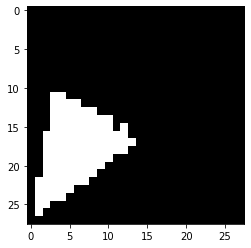

In [36]:
# Show image reconstruction from VAE model

plt.imshow(np.around(recon_imgs_train[546]), cmap="gray", )

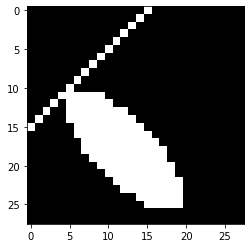

In [37]:
# Show image from train dataset

plt.imshow(x_train_orig[540], cmap="gray",)

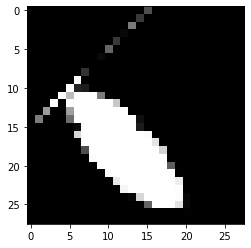

In [38]:
# Show image reconstruction from VAE model

plt.imshow(recon_imgs_train[540], cmap="gray",)

### Show Clean Datapoints at Random

y_noise: 0


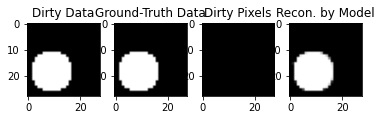

y_noise: 0


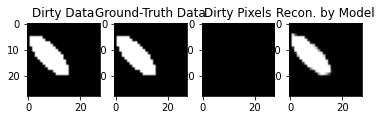

y_noise: 0


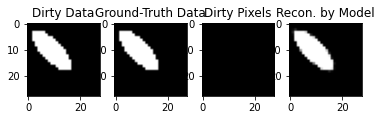

y_noise: 0


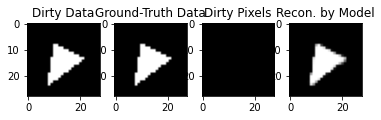

y_noise: 0


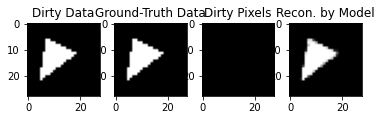

y_noise: 0


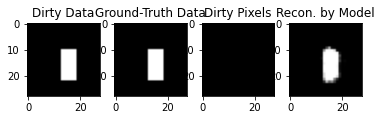

y_noise: 0


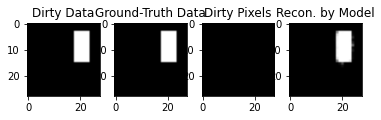

y_noise: 0


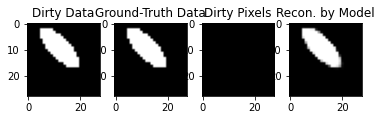

y_noise: 0


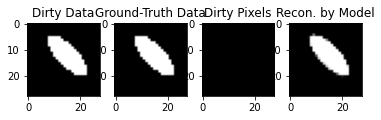

y_noise: 0


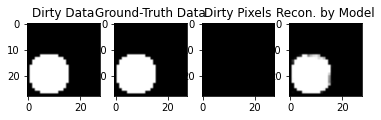

y_noise: 0


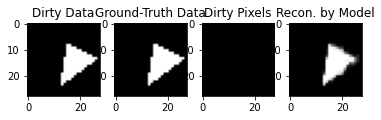

y_noise: 0


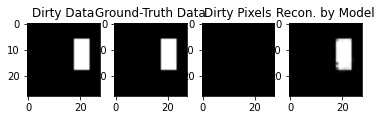

y_noise: 0


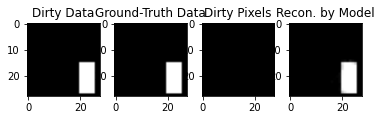

y_noise: 0


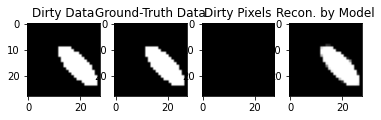

y_noise: 0


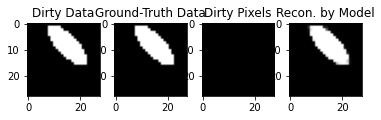

y_noise: 0


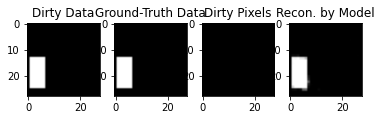

y_noise: 0


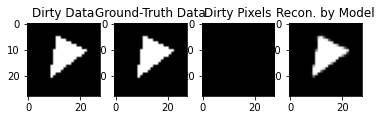

y_noise: 0


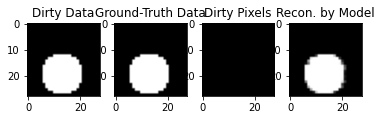

y_noise: 0


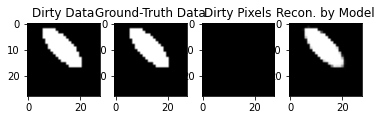

y_noise: 0


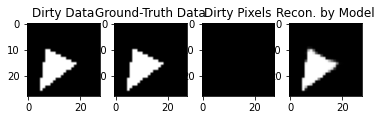

y_noise: 0


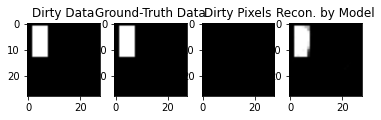

y_noise: 0


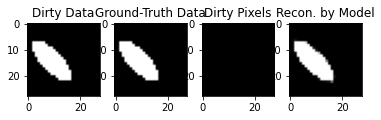

y_noise: 0


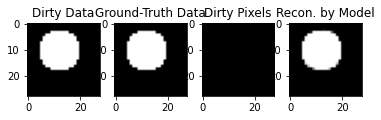

y_noise: 0


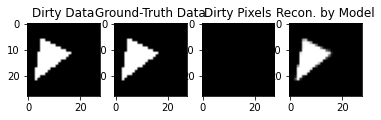

y_noise: 0


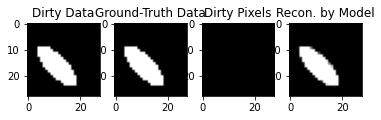

In [39]:
max_imgs_show = 25
y_noise_idxs_train = np.where(~y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()


### Show Dirty Datapoints at Random

y_noise: 1


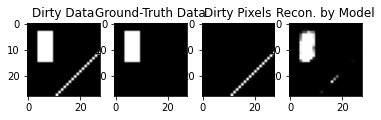

y_noise: 1


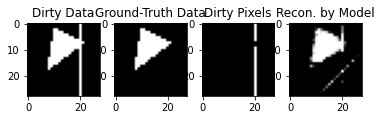

y_noise: 1


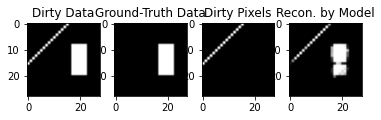

y_noise: 1


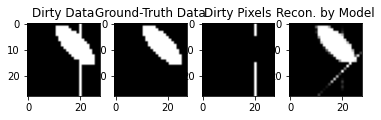

y_noise: 1


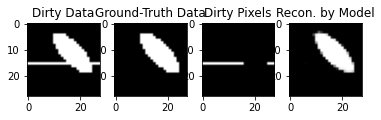

y_noise: 1


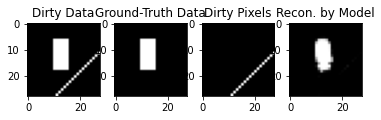

y_noise: 1


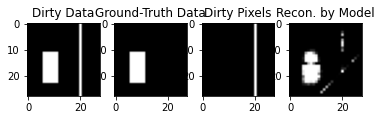

y_noise: 1


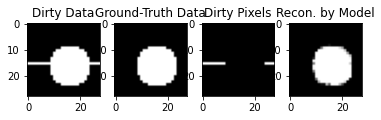

y_noise: 1


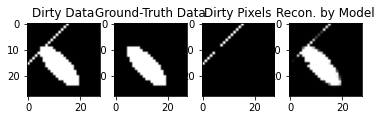

y_noise: 1


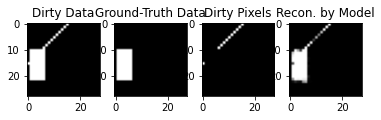

y_noise: 1


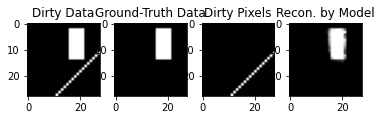

y_noise: 1


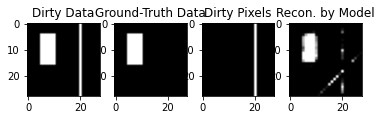

y_noise: 1


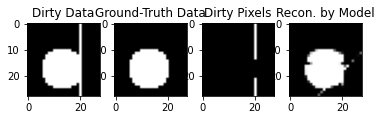

y_noise: 1


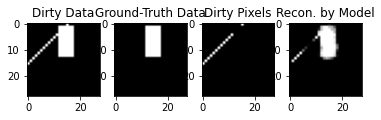

y_noise: 1


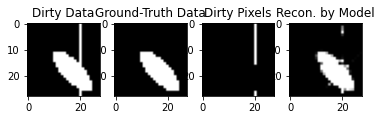

y_noise: 1


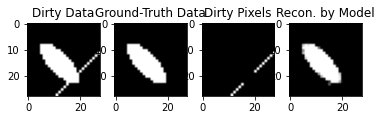

y_noise: 1


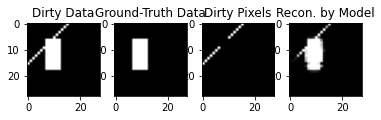

y_noise: 1


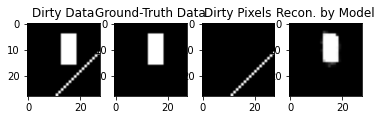

y_noise: 1


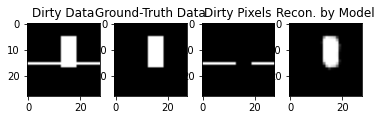

y_noise: 1


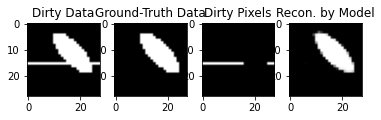

y_noise: 1


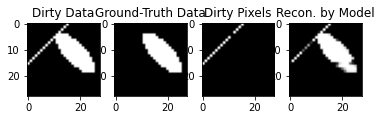

y_noise: 1


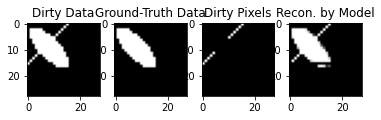

y_noise: 1


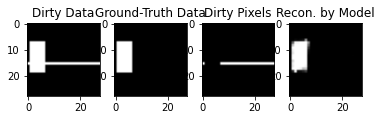

y_noise: 1


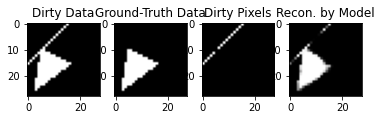

y_noise: 1


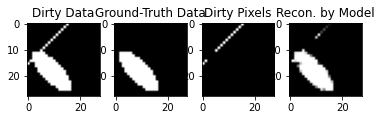

In [40]:
max_imgs_show = 25
y_noise_idxs_train = np.where(y_noise_instance_train)[0]
some_idxs = np.random.permutation(y_noise_idxs_train)[:max_imgs_show]
# y_noise -- 1 if instance dirty; 0 if instance clean. (NOTE: inverted meaning in generative model)
    
for idx in some_idxs:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray", ) # vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray",) #  vmin=0.0, vmax=1.0
    #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[3].set_title("Recon. by Model")
    plt.show()



### Show per noise type images: y_noise_lists or y_noise_dict


Noise Tag: 0
Noise Indices: 
[1074, 2486, 847, 3208, 1286, 1959, 3241, 585, 2609, 223, 1834, 3804, 1618, 3708, 163, 1282, 569, 3417, 2556, 3003, 2868, 3866, 171, 2444, 3327, 3933, 3380, 496, 3591, 1448, 2391, 3229, 3073, 602, 2485, 3833, 3766, 3415, 2189, 1189, 2613, 774, 1218, 2408, 1429, 3566, 2383, 2219, 1782, 1810, 769, 977, 3869, 436, 1907, 1110, 2354, 2791, 175, 1970, 717, 427, 755, 47, 1625, 2283, 3928, 472, 725, 2826, 443, 1470, 1307, 3691, 2013, 1938, 198, 3576, 3279, 2578, 3340, 1542, 703, 1956, 1745, 694, 2946, 1871, 1386, 3194, 1626, 2418, 2123, 2345, 2461, 927, 2366, 1924, 2014, 3196, 2061, 3794, 3474, 2340, 2016, 1923, 1571, 3632, 1979, 1040, 425, 3800, 3040, 3526, 1574, 2691, 621, 3549, 946, 3002, 1479, 1531, 3999, 2441, 3106, 1853, 517, 3359, 1936, 1182, 3363, 3376, 971, 405, 916, 2508, 1930, 2322, 1785, 508, 779, 914, 1195, 3533, 1647, 1301, 1905, 1926, 1294, 2639, 2160, 2173, 2943, 3382, 1848, 85, 2832, 2930, 481, 1248, 3521, 3925, 2845, 534, 2246, 1947, 700, 3967, 62

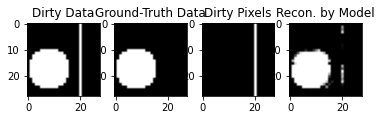

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


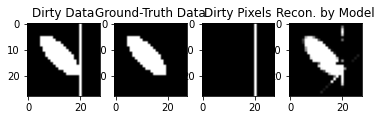

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


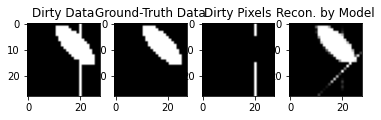

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


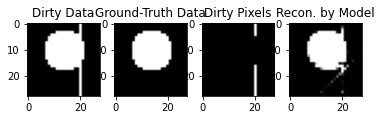

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


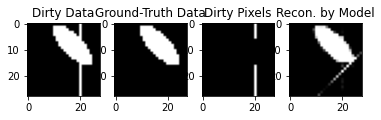

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


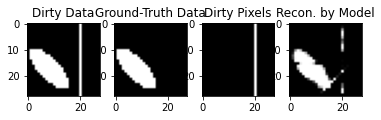

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


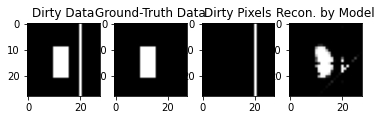

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


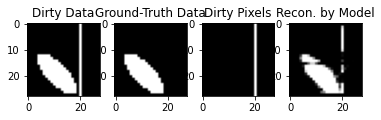

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


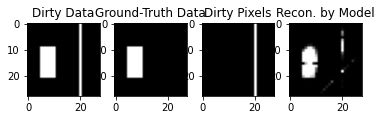

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 0


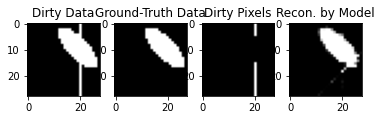







Noise Tag: 1
Noise Indices: 
[2494, 286, 3400, 1695, 3448, 1621, 2518, 3569, 3689, 3683, 1021, 1363, 651, 3134, 611, 2024, 2879, 3515, 2124, 3216, 1760, 1602, 57, 2310, 1895, 529, 2480, 3367, 3758, 561, 2178, 588, 265, 2218, 75, 1513, 1692, 329, 2666, 1250, 734, 2303, 104, 3776, 1567, 1710, 2858, 304, 1787, 3729, 2042, 3393, 345, 962, 642, 2103, 2190, 1224, 2114, 3613, 2595, 2196, 154, 3508, 3711, 2415, 938, 3421, 3, 2665, 2802, 2281, 1018, 3432, 2798, 1126, 1374, 704, 1774, 3817, 2547, 3529, 3978, 3029, 13, 1358, 632, 3910, 817, 376, 1744, 3170, 1950, 1004, 1058, 1207, 1191, 3436, 457, 2818, 650, 3809, 215, 2394, 723, 1026, 229, 2733, 2, 3771, 3233, 285, 1245, 365, 1098, 3390, 702, 2596, 3045, 3242, 2456, 1931, 1029, 320, 3466, 3405, 2829, 996, 283, 3410, 3901, 763, 1138, 237, 3088, 3617, 3681, 3065, 1801, 2874, 2900, 2931, 587, 2305, 1468, 339, 3567, 1263, 2191, 550, 2502, 3594, 66, 3025, 1707, 3899, 2187, 1533, 3462, 2070, 296, 1990, 3525, 2323, 1315, 374, 3947, 3547, 3627, 20

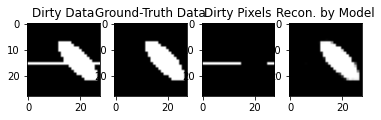

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


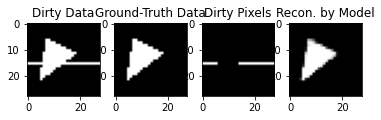

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


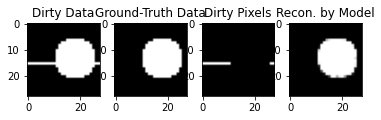

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


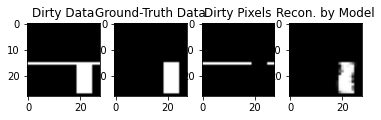

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


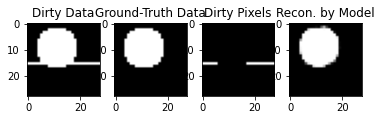

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


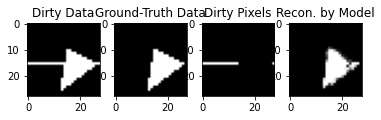

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


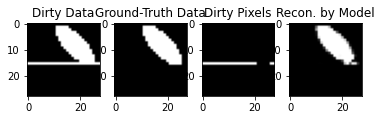

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


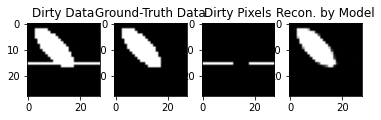

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


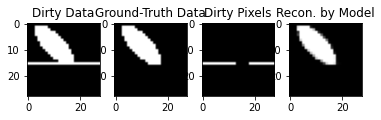

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 1


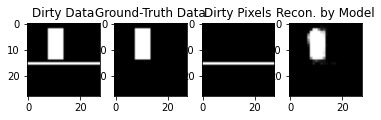







Noise Tag: 2
Noise Indices: 
[3287, 2577, 3902, 2709, 280, 640, 3014, 574, 248, 1090, 2158, 2164, 3353, 521, 24, 1549, 1412, 3243, 3222, 2021, 760, 2893, 854, 3676, 1822, 2567, 2777, 444, 2155, 3322, 1199, 2736, 212, 605, 2458, 1382, 1767, 3994, 1023, 735, 3074, 1627, 3541, 3789, 3907, 3477, 108, 731, 988, 253, 219, 3488, 1739, 488, 3153, 3274, 3812, 2847, 3517, 3111, 736, 3922, 3888, 838, 3148, 21, 382, 1401, 469, 1354, 3494, 1406, 199, 3101, 1749, 2237, 861, 244, 416, 3923, 1230, 751, 568, 3524, 732, 535, 1597, 3163, 3486, 2541, 2121, 1394, 3184, 1033, 370, 1439, 3532, 625, 3375, 3048, 786, 1463, 1994, 2232, 1091, 101, 1454, 3309, 1206, 1863, 3112, 2935, 886, 1444, 3643, 3404, 1279, 2972, 315, 148, 672, 1087, 1024, 3237, 1234, 1216, 1672, 3824, 1162, 1208, 3527, 1657, 1667, 2068, 3203, 2448, 3915, 318, 656, 943, 307, 1329, 1212, 3951, 391, 194, 816, 3411, 679, 1326, 526, 3602, 2241, 3094, 3064, 581, 1285, 281, 2591, 2606, 3461, 1591, 863, 3136, 3253, 3133, 274, 1311, 1519, 3036

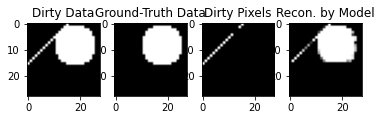

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


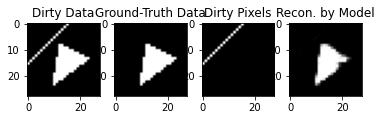

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


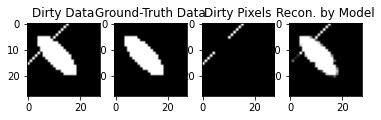

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


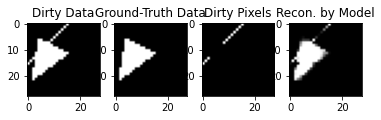

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


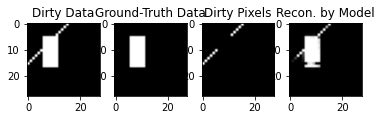

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


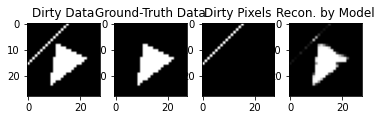

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


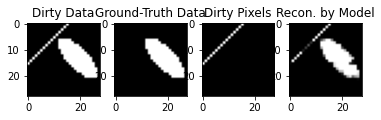

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


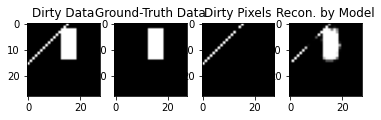

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


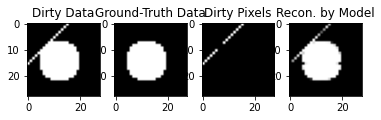

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 2


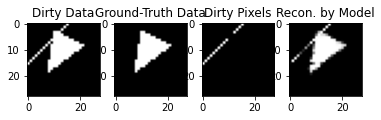







Noise Tag: 3
Noise Indices: 
[893, 202, 42, 2702, 1243, 3548, 3316, 3100, 2558, 2181, 3126, 1974, 1932, 3395, 1875, 2688, 394, 1253, 3490, 1001, 532, 3302, 3830, 684, 3697, 726, 693, 1844, 815, 1849, 870, 234, 1009, 3299, 937, 966, 1438, 2206, 1507, 2682, 1537, 2051, 1901, 2966, 1421, 3337, 3219, 3742, 1178, 2392, 810, 589, 297, 900, 2250, 2864, 1164, 3444, 3396, 2627, 2805, 2449, 2778, 3619, 2171, 3028, 873, 2548, 3572, 2797, 2538, 2435, 1289, 3024, 1802, 1645, 3612, 2212, 3763, 3956, 969, 1462, 3858, 2017, 485, 3780, 420, 3540, 3082, 951, 3853, 2721, 1046, 2511, 118, 1449, 476, 3714, 3563, 2951, 1933, 3458, 2906, 3429, 2108, 3171, 266, 68, 1214, 259, 1435, 3737, 2555, 2174, 216, 3864, 37, 3701, 1048, 317, 3657, 2497, 2285, 813, 81, 76, 3670, 842, 818, 359, 869, 565, 3652, 3290, 401, 2455, 980, 2539, 2959, 1966, 756, 1656, 609, 1176, 2221, 1028, 1980, 2139, 2960, 3531, 182, 3738, 784, 3188, 399, 2244, 2697, 245, 269, 2938, 2597, 428, 1318, 1577, 408, 1754, 1314, 1005, 3813, 3554

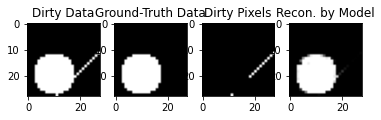

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


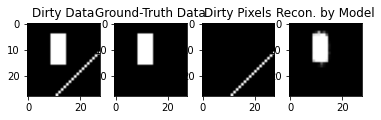

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


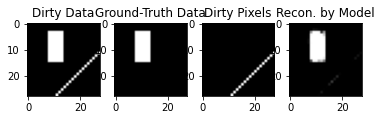

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


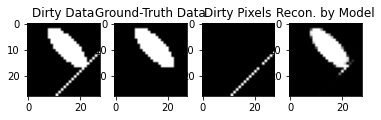

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


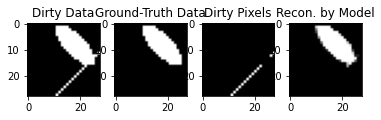

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


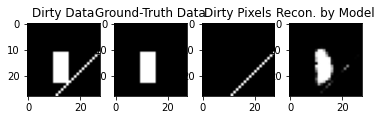

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


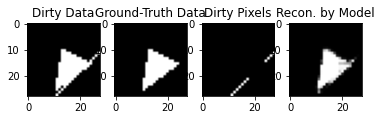

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


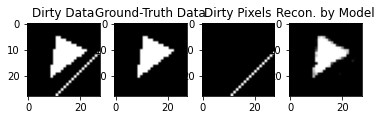

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


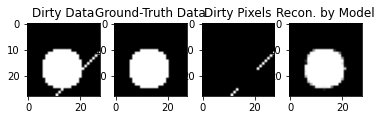

y_class (clean): 0 | y_noise: True | y_noise_tag (noise type): 3


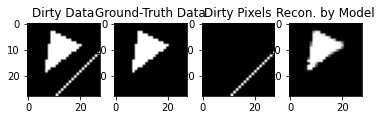

In [41]:
## show per noise type images: y_noise_lists or y_noise_dict

max_show_n = 10

for noise_key, noise_idxs in y_noise_dict_train.items():
    
    print("Noise Tag: {}".format(noise_key))
    print("Noise Indices: \n{}".format(noise_idxs))
    
    _selected_idxs = np.random.permutation(noise_idxs)[:max_show_n]
    
    for idx in _selected_idxs:
    
        print("y_class (clean): {} | y_noise: {} | y_noise_tag (noise type): {}".format(
            0, y_noise_instance_train[idx], noise_key)) # y_class_train[idx]
        fig, ax = plt.subplots(1,4)
        ax[0].imshow(x_train_orig[idx,...],cmap="gray")
        ax[0].set_title("Dirty Data")
        ax[1].imshow(x_train_clean_orig[idx,...],cmap="gray")
        ax[1].set_title("Ground-Truth Data")
        ax[2].imshow(y_noise_pixels_train[idx,...],cmap="gray")
        ax[2].set_title("Dirty Pixels")
        #ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
        ax[3].set_title("Recon. by Model")
        plt.show()
        
    print("\n\n\n\n\n")



### Show Trusted Set (Clean Ground-Truth, Train Data, Recon)

In [42]:
len(trusted_idxs_train)

400

y_noise: 0


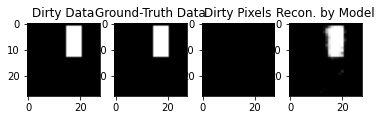

y_noise: 0


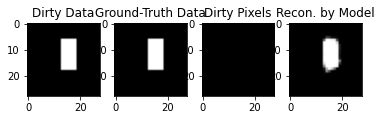

y_noise: 0


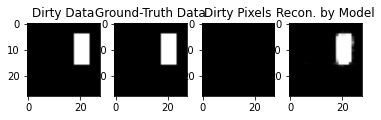

y_noise: 0


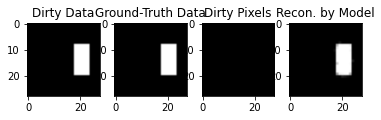

y_noise: 0


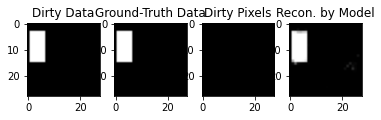

y_noise: 0


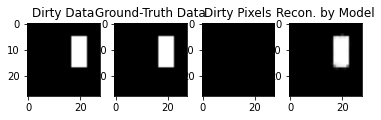

y_noise: 0


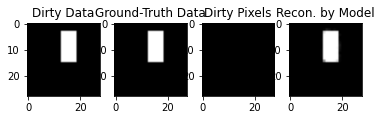

y_noise: 0


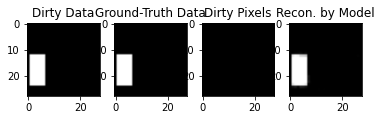

y_noise: 0


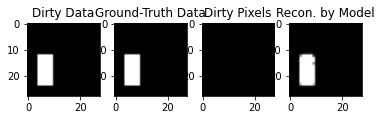

y_noise: 0


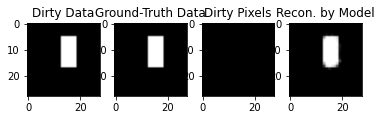

y_noise: 0


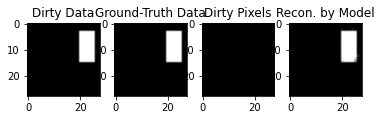

y_noise: 0


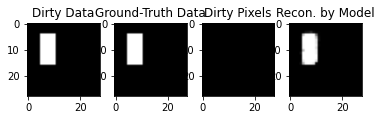

y_noise: 0


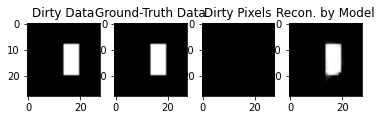

y_noise: 0


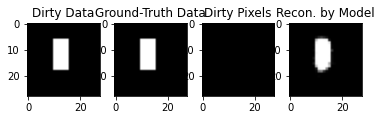

y_noise: 0


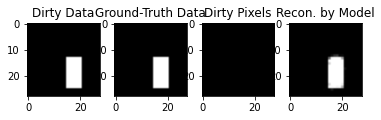

y_noise: 0


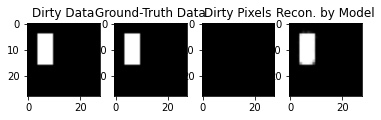

y_noise: 0


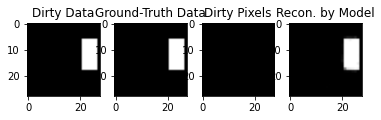

y_noise: 0


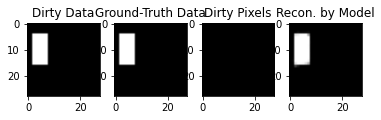

y_noise: 0


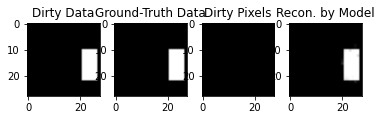

y_noise: 0


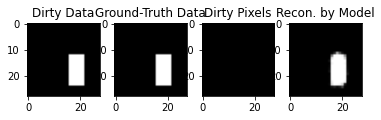

y_noise: 0


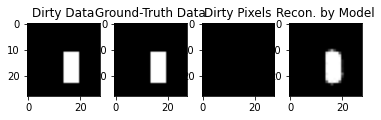

y_noise: 0


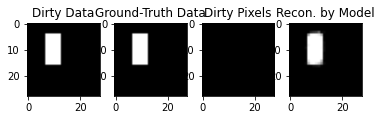

y_noise: 0


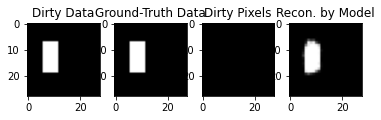

y_noise: 0


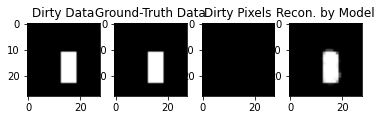

y_noise: 0


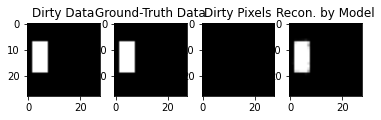

y_noise: 0


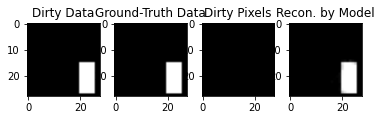

y_noise: 0


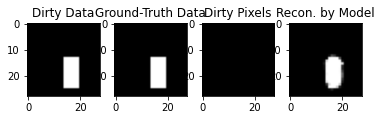

y_noise: 0


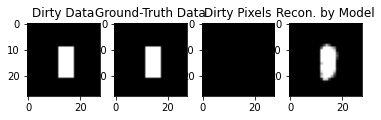

y_noise: 0


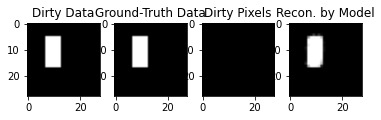

y_noise: 0


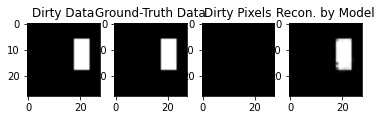

y_noise: 0


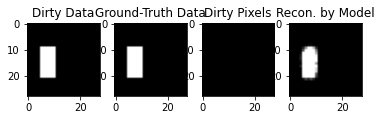

y_noise: 0


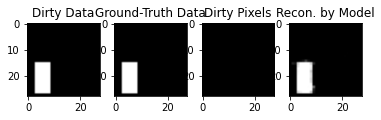

y_noise: 0


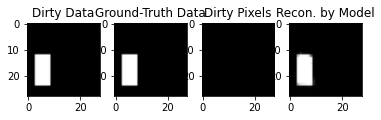

y_noise: 0


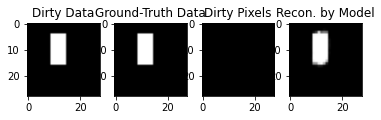

y_noise: 0


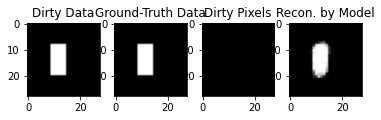

y_noise: 0


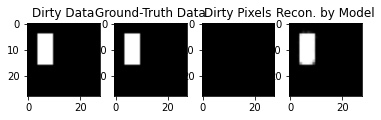

y_noise: 0


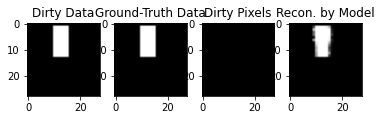

y_noise: 0


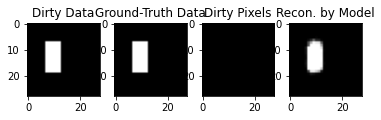

y_noise: 0


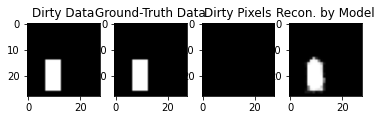

y_noise: 0


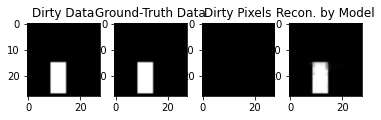

y_noise: 0


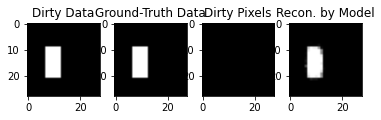

y_noise: 0


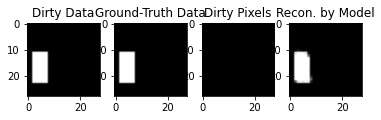

y_noise: 0


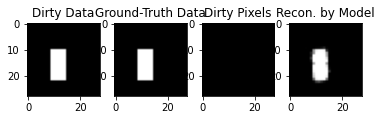

y_noise: 0


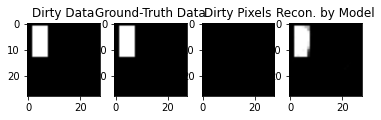

y_noise: 0


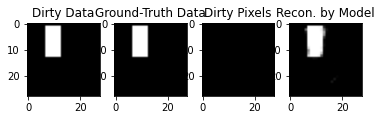

y_noise: 0


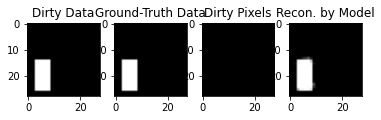

y_noise: 0


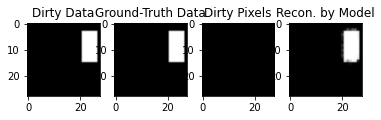

y_noise: 0


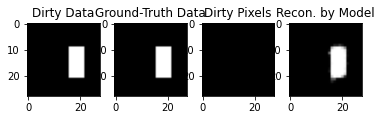

y_noise: 0


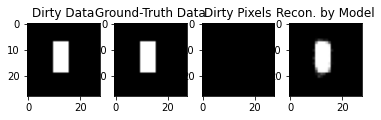

y_noise: 0


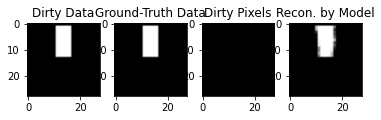

y_noise: 0


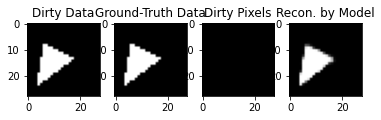

y_noise: 0


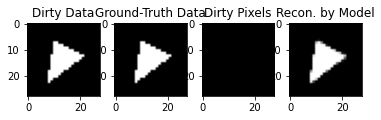

y_noise: 0


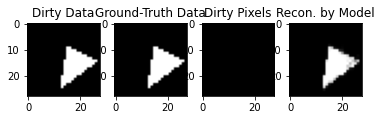

y_noise: 0


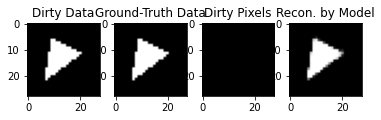

y_noise: 0


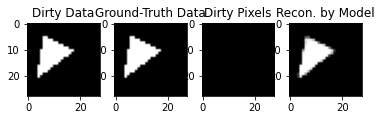

y_noise: 0


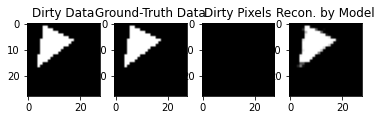

y_noise: 0


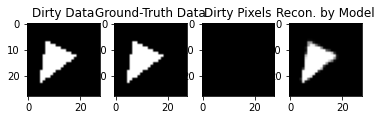

y_noise: 0


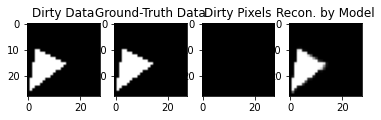

y_noise: 0


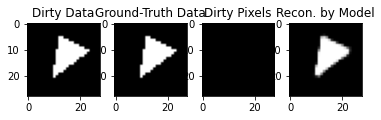

y_noise: 0


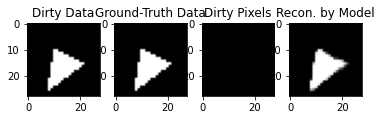

y_noise: 0


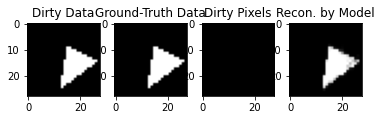

y_noise: 0


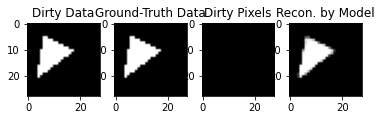

y_noise: 0


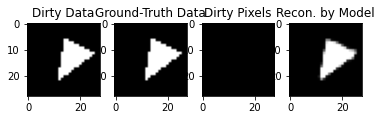

y_noise: 0


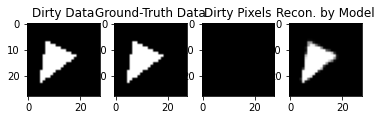

y_noise: 0


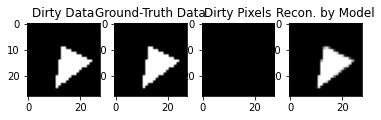

y_noise: 0


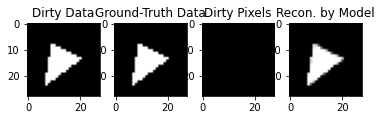

y_noise: 0


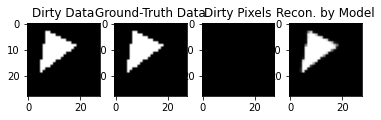

y_noise: 0


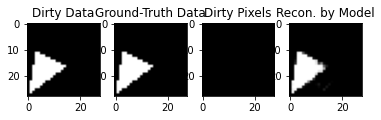

y_noise: 0


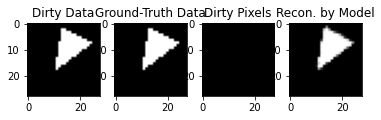

y_noise: 0


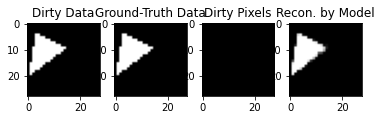

y_noise: 0


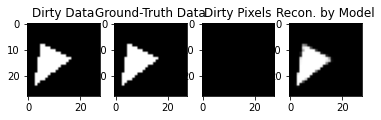

y_noise: 0


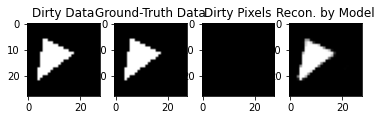

y_noise: 0


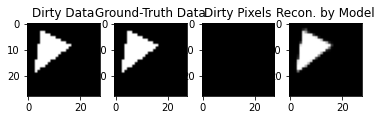

y_noise: 0


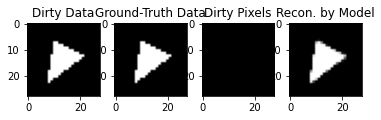

y_noise: 0


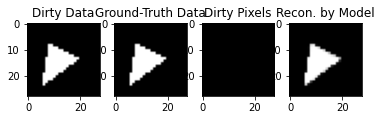

y_noise: 0


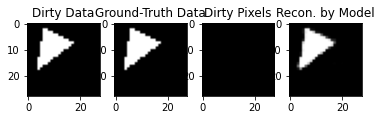

y_noise: 0


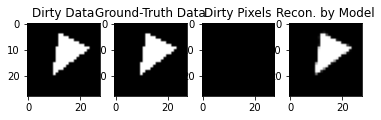

y_noise: 0


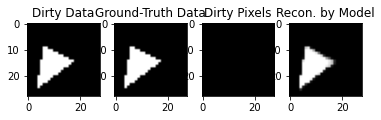

y_noise: 0


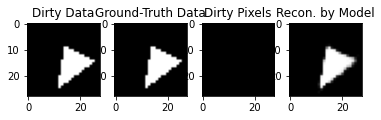

y_noise: 0


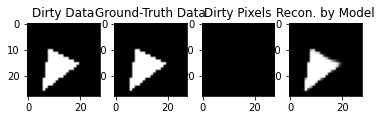

y_noise: 0


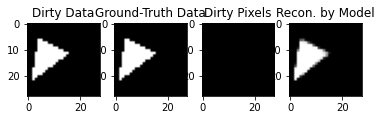

y_noise: 0


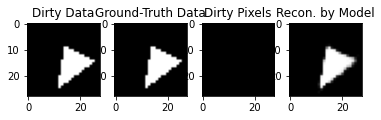

y_noise: 0


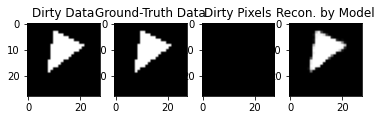

y_noise: 0


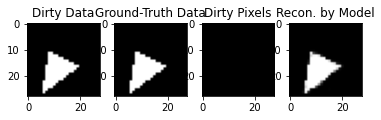

y_noise: 0


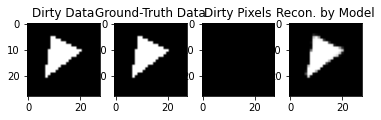

y_noise: 0


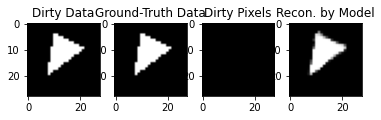

y_noise: 0


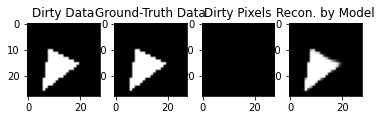

y_noise: 0


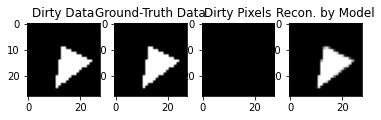

y_noise: 0


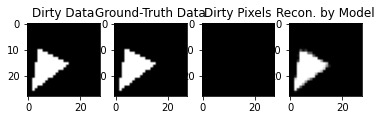

y_noise: 0


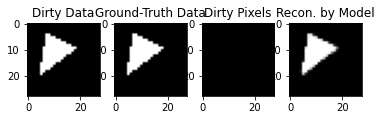

y_noise: 0


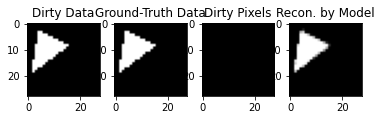

y_noise: 0


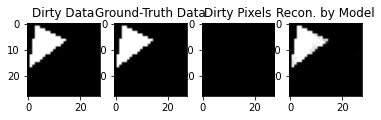

y_noise: 0


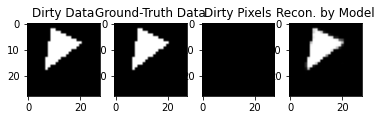

y_noise: 0


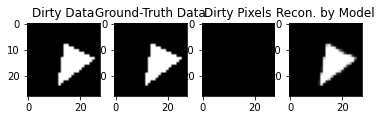

y_noise: 0


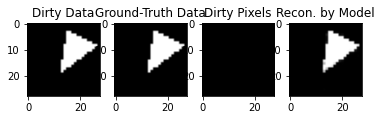

y_noise: 0


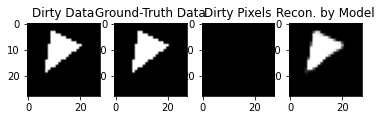

y_noise: 0


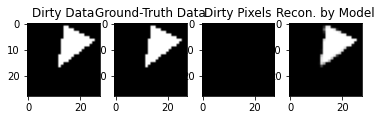

y_noise: 0


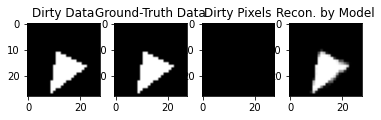

y_noise: 0


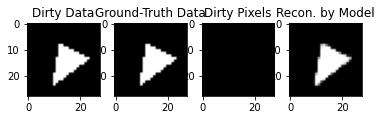

y_noise: 0


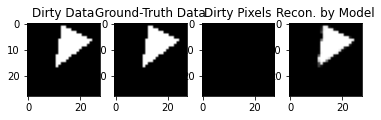

y_noise: 0


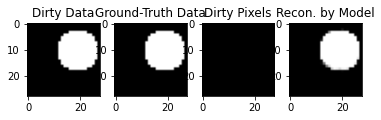

y_noise: 0


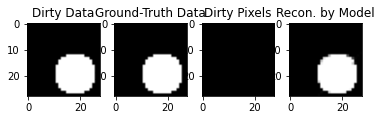

y_noise: 0


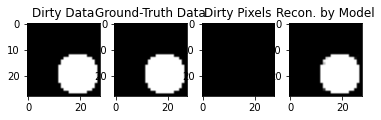

y_noise: 0


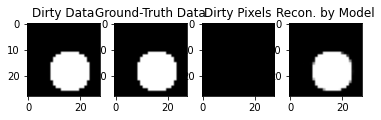

y_noise: 0


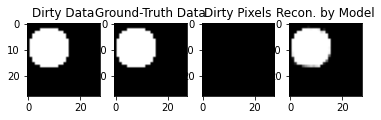

y_noise: 0


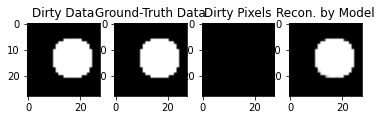

y_noise: 0


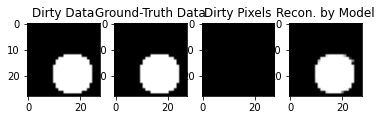

y_noise: 0


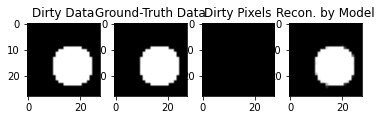

y_noise: 0


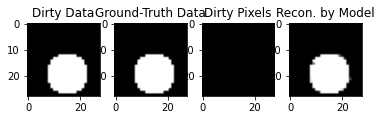

y_noise: 0


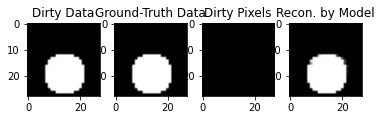

y_noise: 0


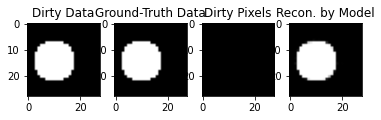

y_noise: 0


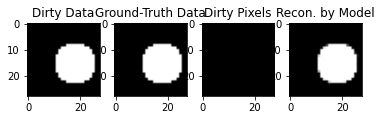

y_noise: 0


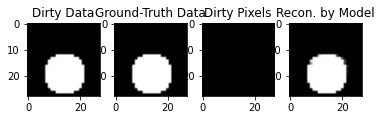

y_noise: 0


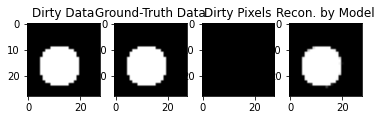

y_noise: 0


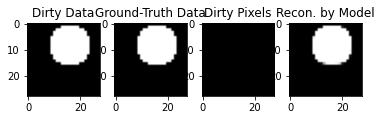

y_noise: 0


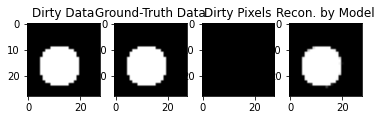

y_noise: 0


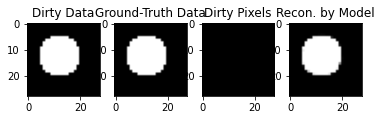

y_noise: 0


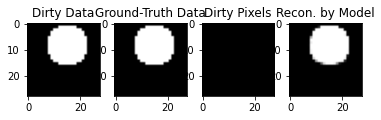

y_noise: 0


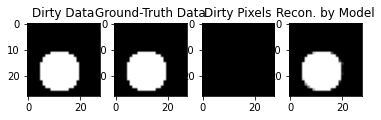

y_noise: 0


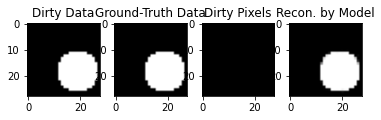

y_noise: 0


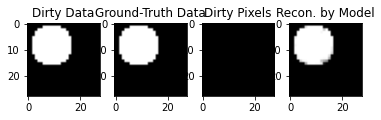

y_noise: 0


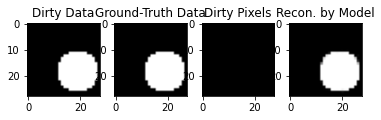

y_noise: 0


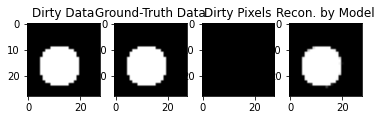

y_noise: 0


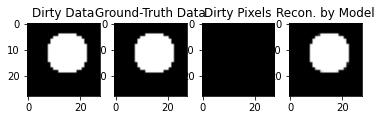

y_noise: 0


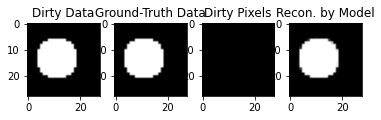

y_noise: 0


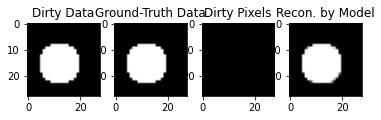

y_noise: 0


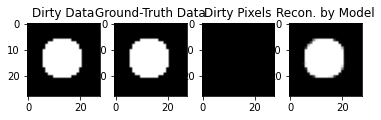

y_noise: 0


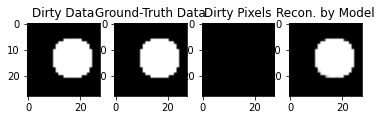

y_noise: 0


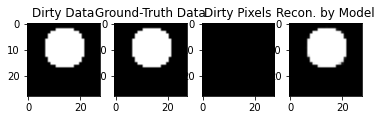

y_noise: 0


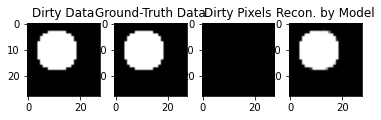

y_noise: 0


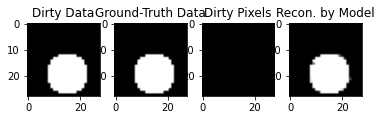

y_noise: 0


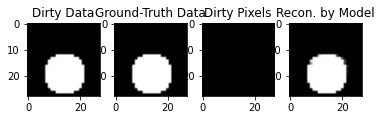

y_noise: 0


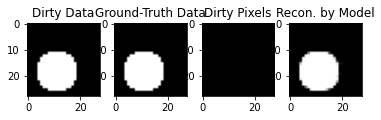

y_noise: 0


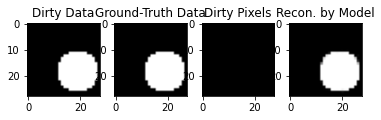

y_noise: 0


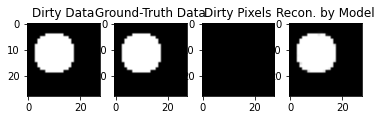

y_noise: 0


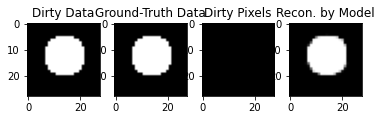

y_noise: 0


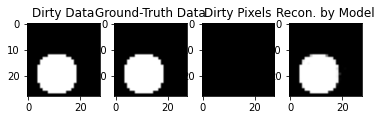

y_noise: 0


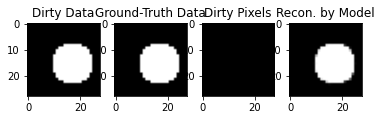

y_noise: 0


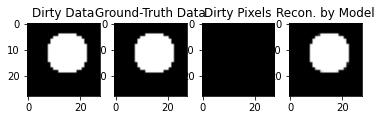

y_noise: 0


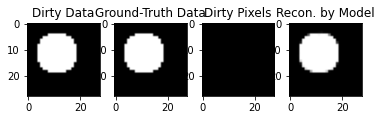

y_noise: 0


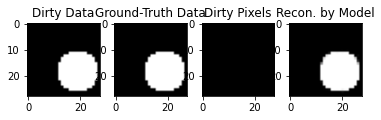

y_noise: 0


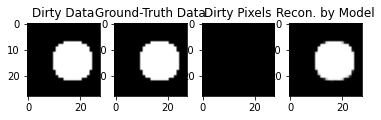

y_noise: 0


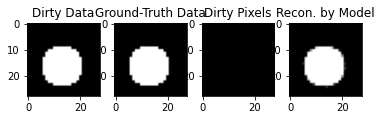

y_noise: 0


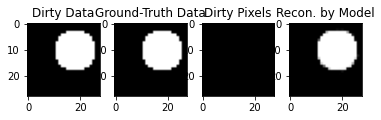

y_noise: 0


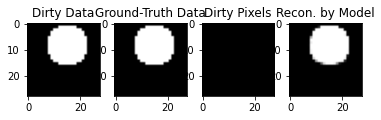

y_noise: 0


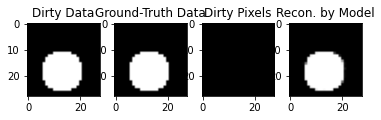

y_noise: 0


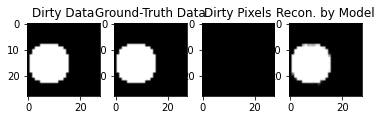

y_noise: 0


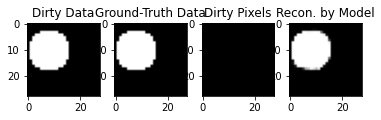

y_noise: 0


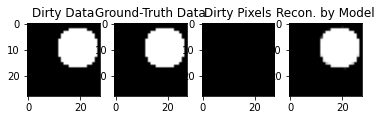

y_noise: 0


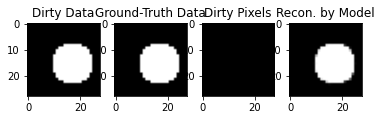

y_noise: 0


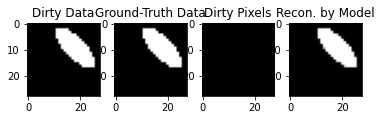

y_noise: 0


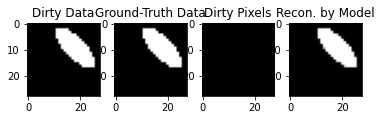

y_noise: 0


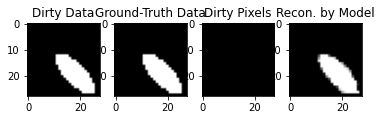

y_noise: 0


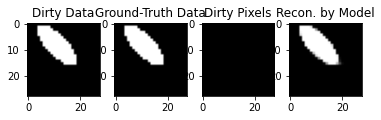

y_noise: 0


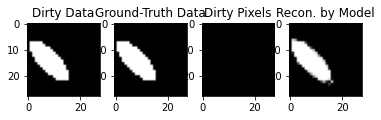

y_noise: 0


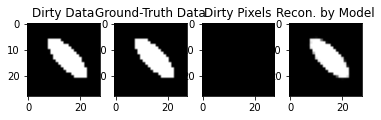

y_noise: 0


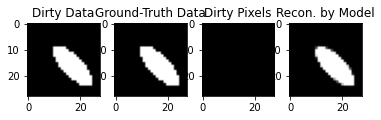

y_noise: 0


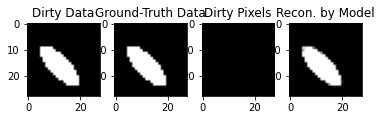

y_noise: 0


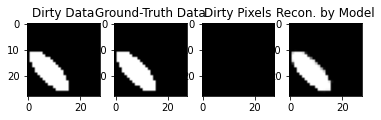

y_noise: 0


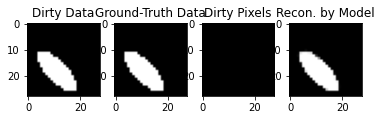

y_noise: 0


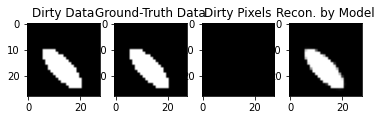

y_noise: 0


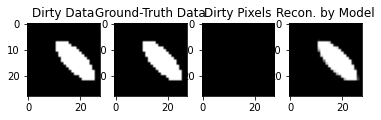

y_noise: 0


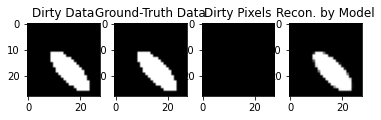

y_noise: 0


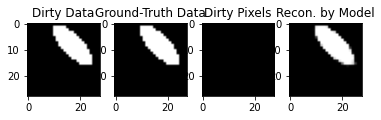

y_noise: 0


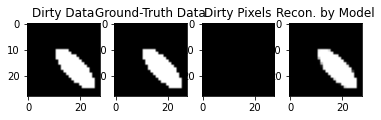

y_noise: 0


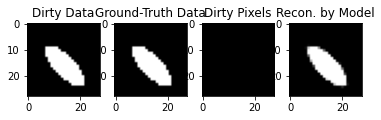

y_noise: 0


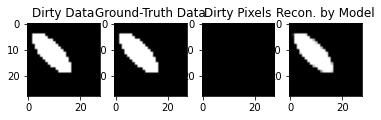

y_noise: 0


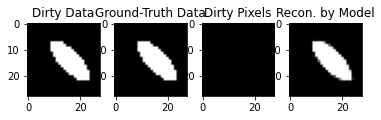

y_noise: 0


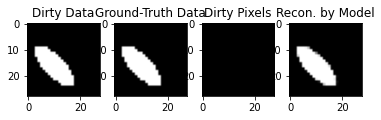

y_noise: 0


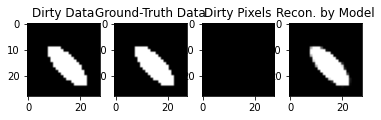

y_noise: 0


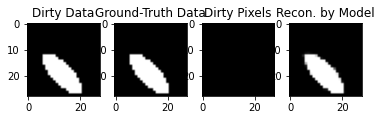

y_noise: 0


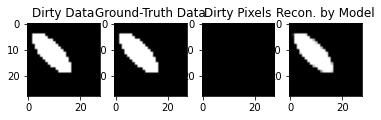

y_noise: 0


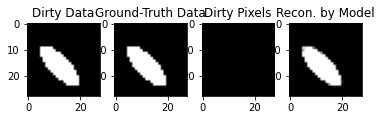

y_noise: 0


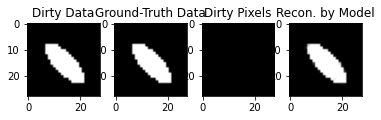

y_noise: 0


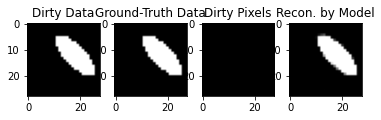

y_noise: 0


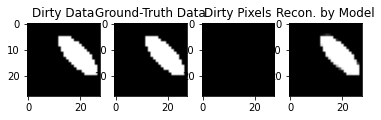

y_noise: 0


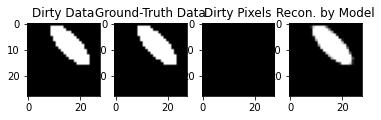

y_noise: 0


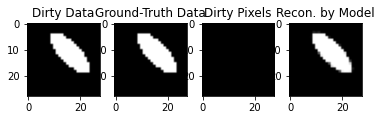

y_noise: 0


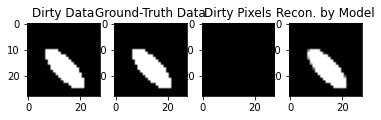

y_noise: 0


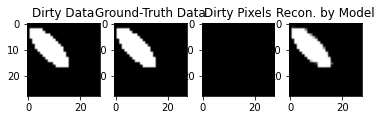

y_noise: 0


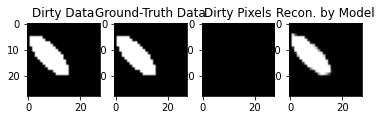

y_noise: 0


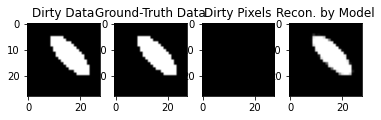

y_noise: 0


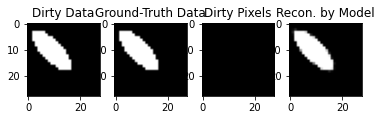

y_noise: 0


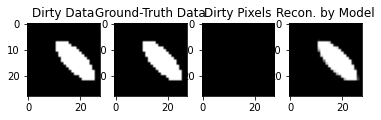

y_noise: 0


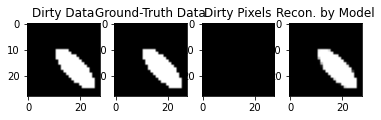

y_noise: 0


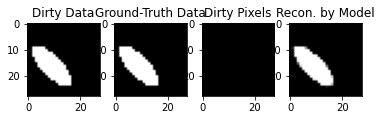

y_noise: 0


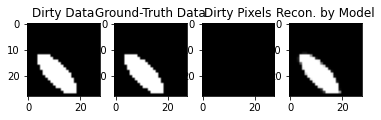

y_noise: 0


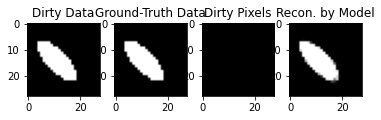

y_noise: 0


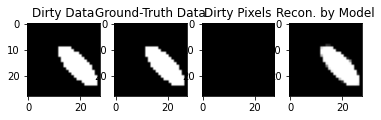

y_noise: 0


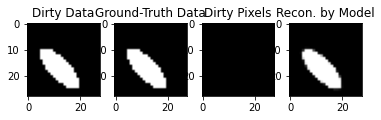

y_noise: 0


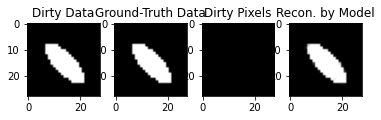

y_noise: 0


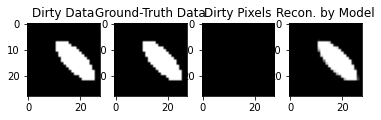

y_noise: 0


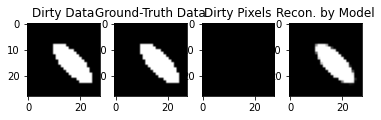

y_noise: 0


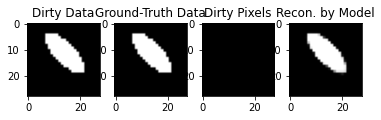

y_noise: 0


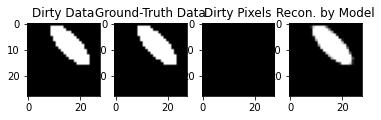

y_noise: 0


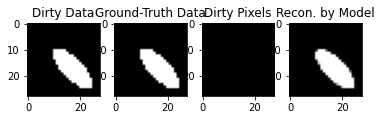

y_noise: 0


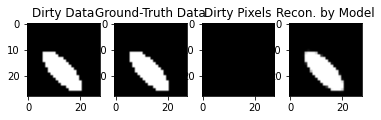

y_noise: 0


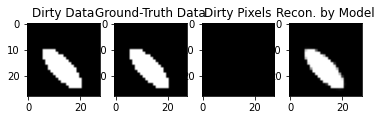

y_noise: 0


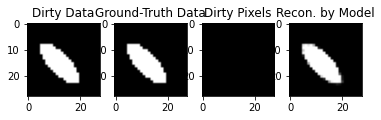

y_noise: 0


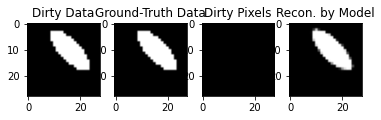

y_noise: 1


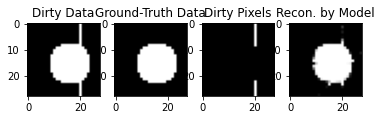

y_noise: 1


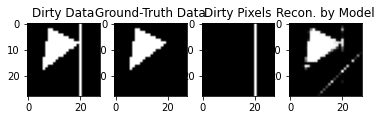

y_noise: 1


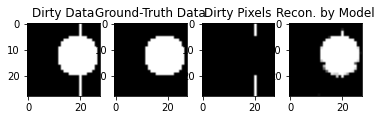

y_noise: 1


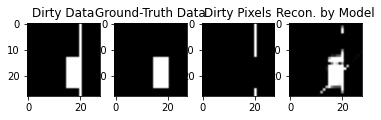

y_noise: 1


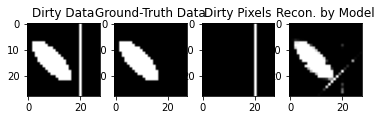

y_noise: 1


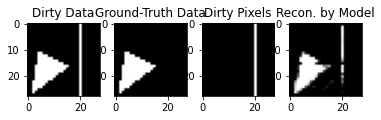

y_noise: 1


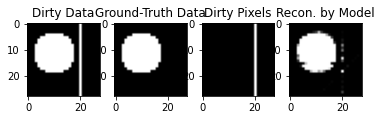

y_noise: 1


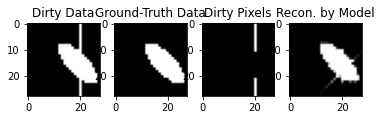

y_noise: 1


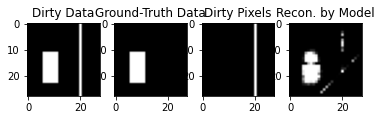

y_noise: 1


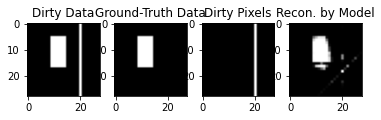

y_noise: 1


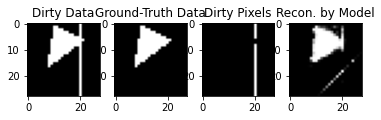

y_noise: 1


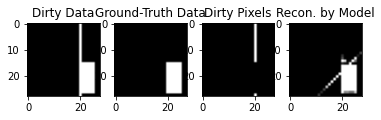

y_noise: 1


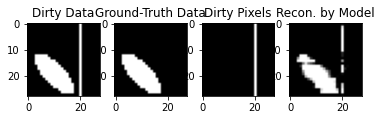

y_noise: 1


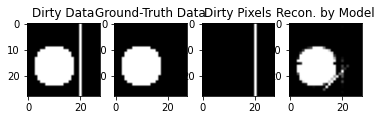

y_noise: 1


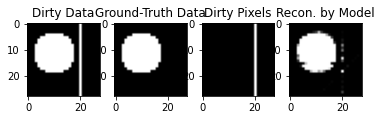

y_noise: 1


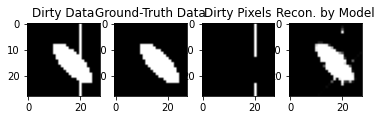

y_noise: 1


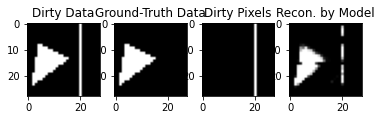

y_noise: 1


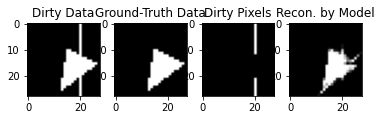

y_noise: 1


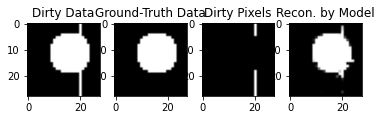

y_noise: 1


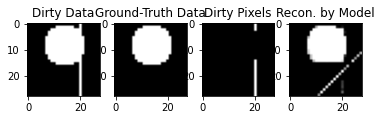

y_noise: 1


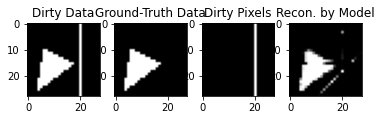

y_noise: 1


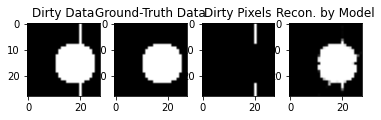

y_noise: 1


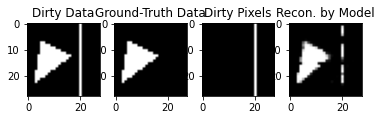

y_noise: 1


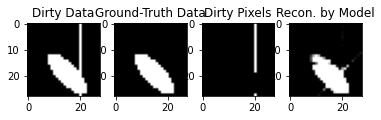

y_noise: 1


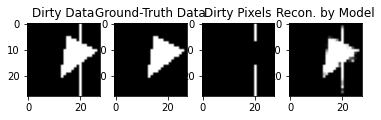

y_noise: 1


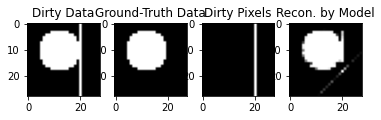

y_noise: 1


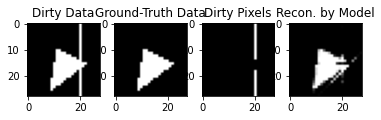

y_noise: 1


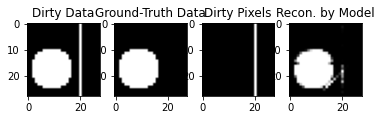

y_noise: 1


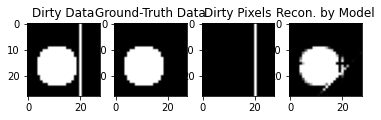

y_noise: 1


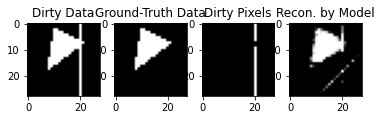

y_noise: 1


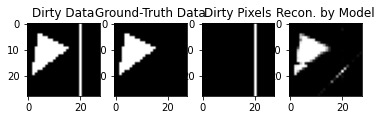

y_noise: 1


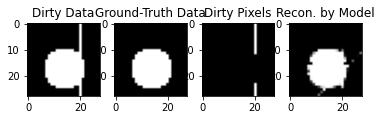

y_noise: 1


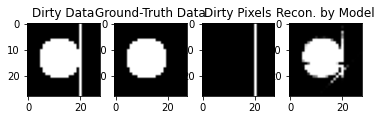

y_noise: 1


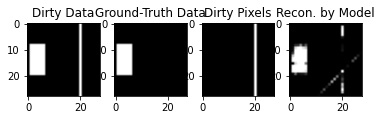

y_noise: 1


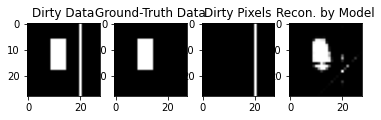

y_noise: 1


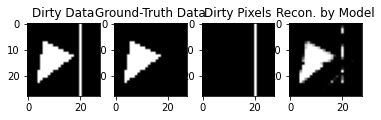

y_noise: 1


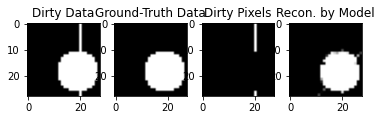

y_noise: 1


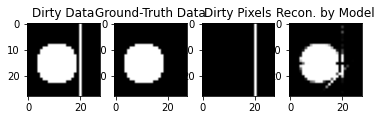

y_noise: 1


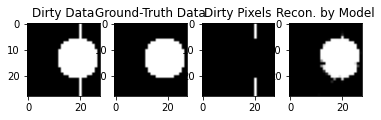

y_noise: 1


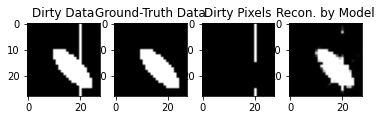

y_noise: 1


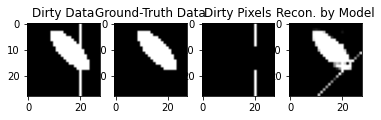

y_noise: 1


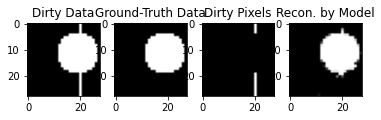

y_noise: 1


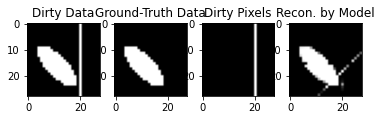

y_noise: 1


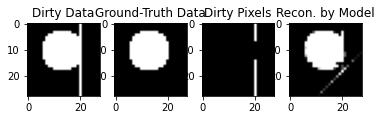

y_noise: 1


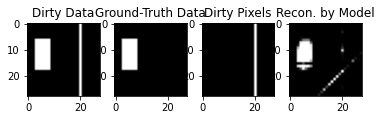

y_noise: 1


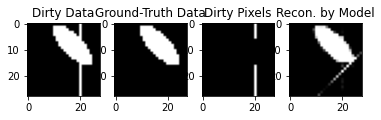

y_noise: 1


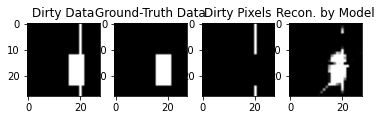

y_noise: 1


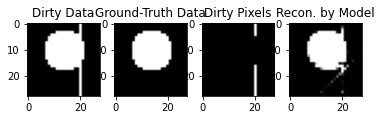

y_noise: 1


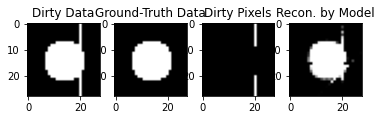

y_noise: 1


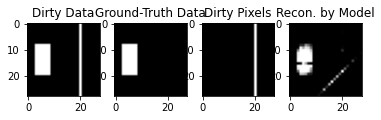

y_noise: 1


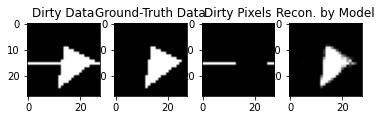

y_noise: 1


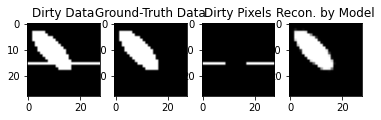

y_noise: 1


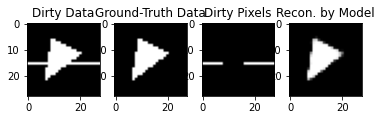

y_noise: 1


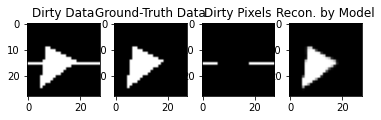

y_noise: 1


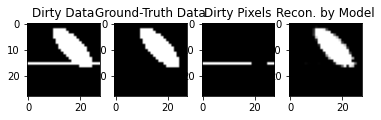

y_noise: 1


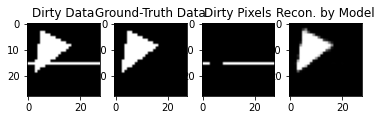

y_noise: 1


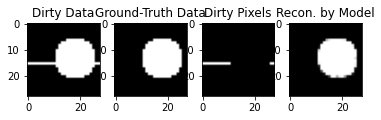

y_noise: 1


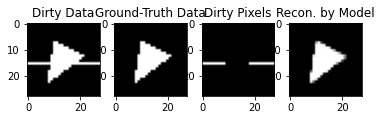

y_noise: 1


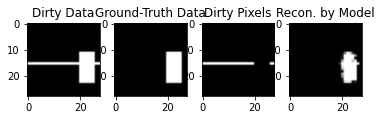

y_noise: 1


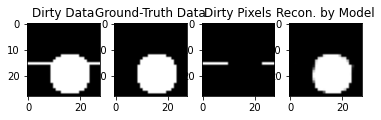

y_noise: 1


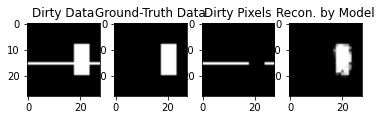

y_noise: 1


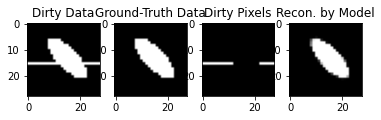

y_noise: 1


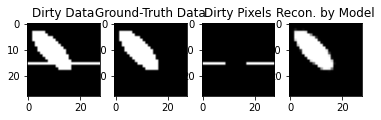

y_noise: 1


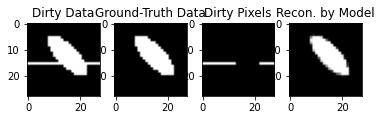

y_noise: 1


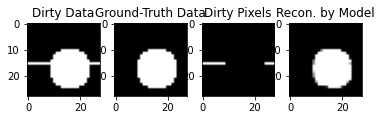

y_noise: 1


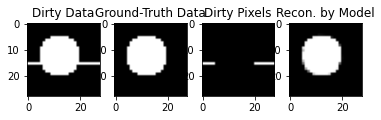

y_noise: 1


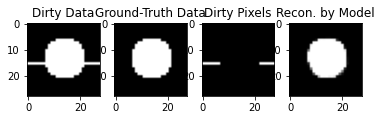

y_noise: 1


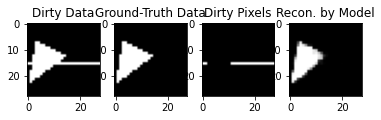

y_noise: 1


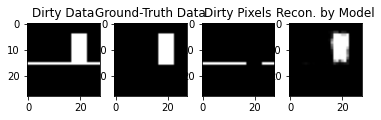

y_noise: 1


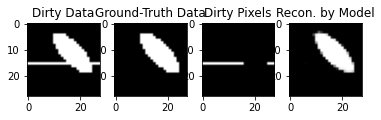

y_noise: 1


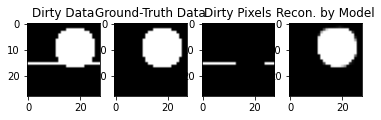

y_noise: 1


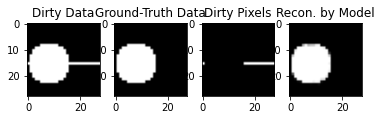

y_noise: 1


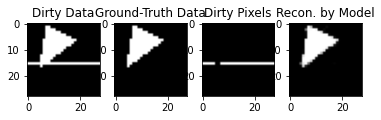

y_noise: 1


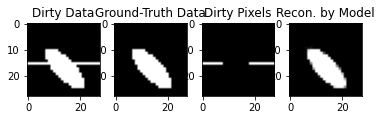

y_noise: 1


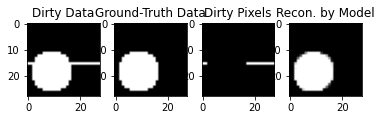

y_noise: 1


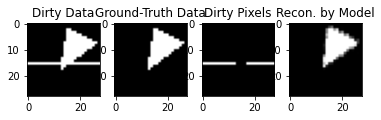

y_noise: 1


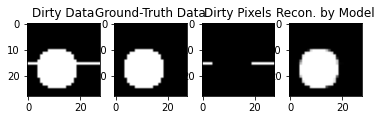

y_noise: 1


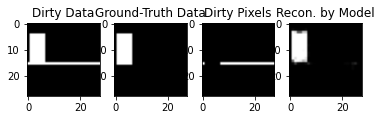

y_noise: 1


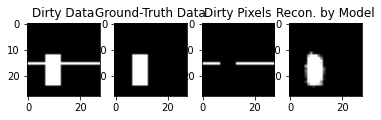

y_noise: 1


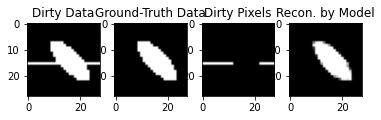

y_noise: 1


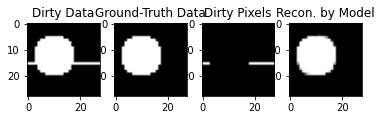

y_noise: 1


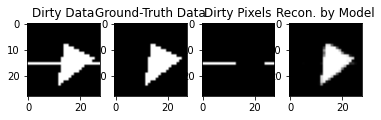

y_noise: 1


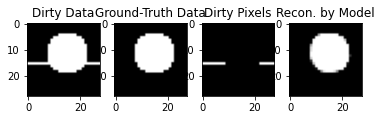

y_noise: 1


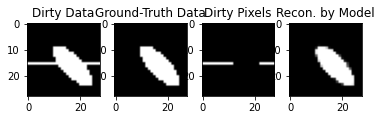

y_noise: 1


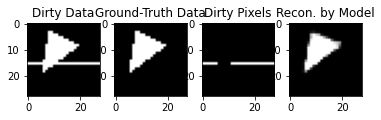

y_noise: 1


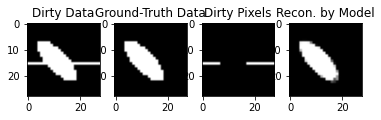

y_noise: 1


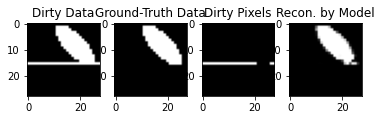

y_noise: 1


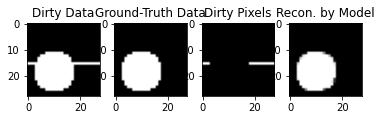

y_noise: 1


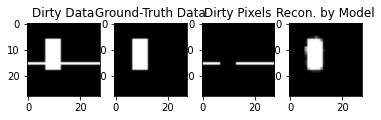

y_noise: 1


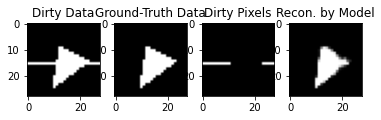

y_noise: 1


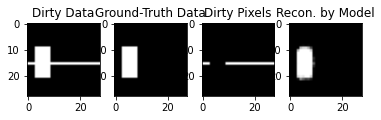

y_noise: 1


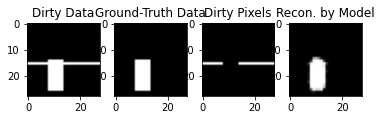

y_noise: 1


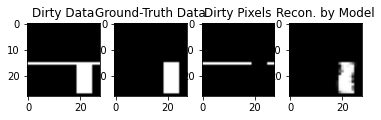

y_noise: 1


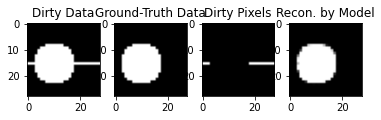

y_noise: 1


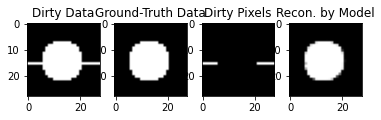

y_noise: 1


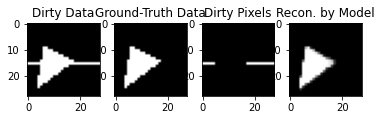

y_noise: 1


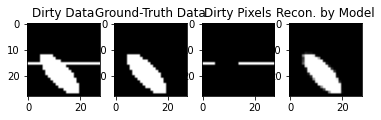

y_noise: 1


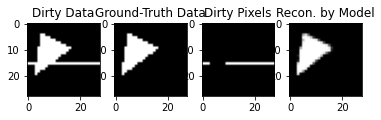

y_noise: 1


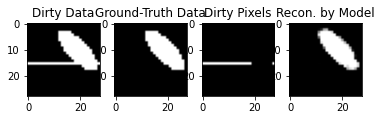

y_noise: 1


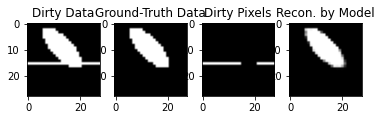

y_noise: 1


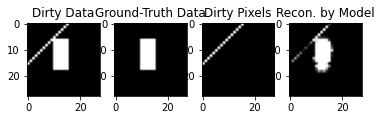

y_noise: 1


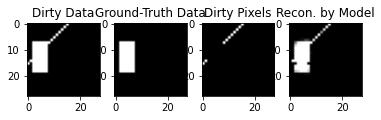

y_noise: 1


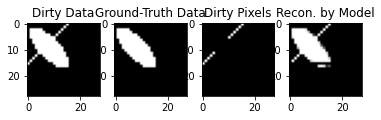

y_noise: 1


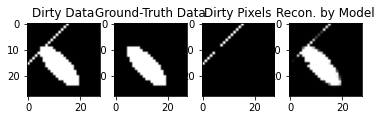

y_noise: 1


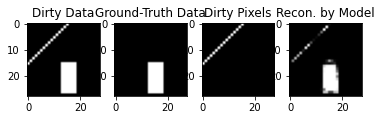

y_noise: 1


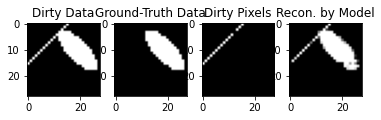

y_noise: 1


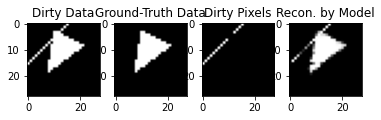

y_noise: 1


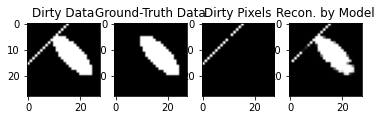

y_noise: 1


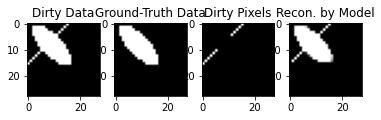

y_noise: 1


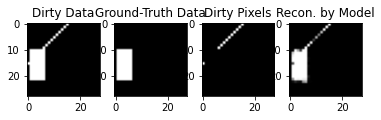

y_noise: 1


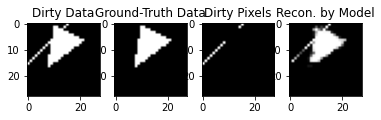

y_noise: 1


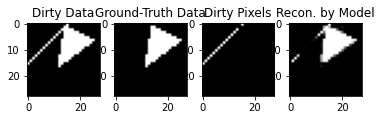

y_noise: 1


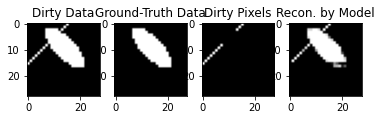

y_noise: 1


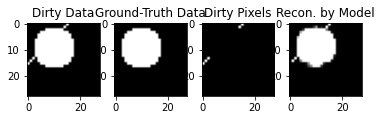

y_noise: 1


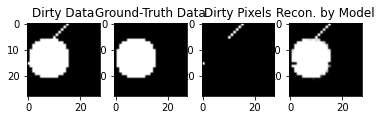

y_noise: 1


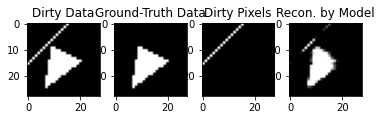

y_noise: 1


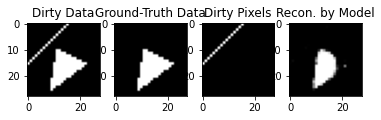

y_noise: 1


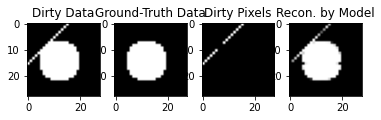

y_noise: 1


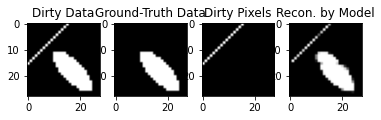

y_noise: 1


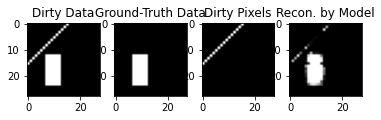

y_noise: 1


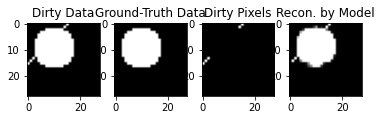

y_noise: 1


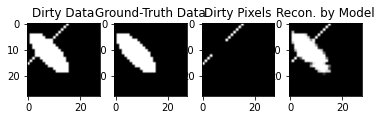

y_noise: 1


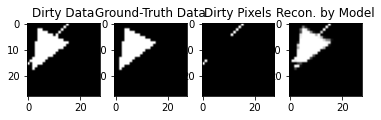

y_noise: 1


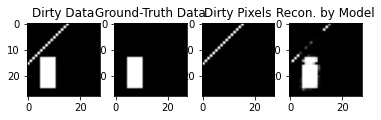

y_noise: 1


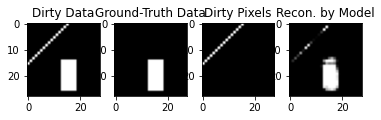

y_noise: 1


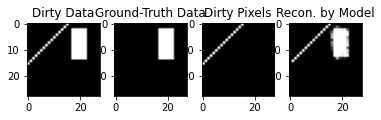

y_noise: 1


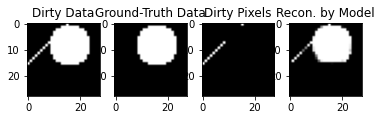

y_noise: 1


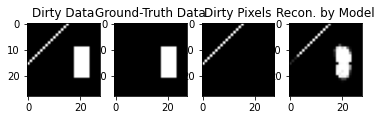

y_noise: 1


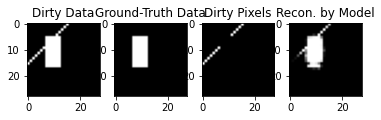

y_noise: 1


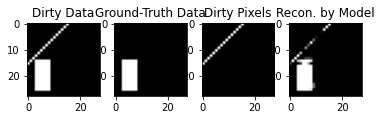

y_noise: 1


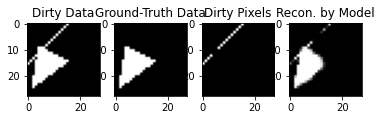

y_noise: 1


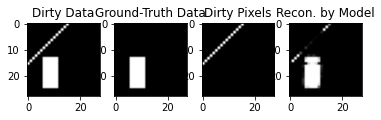

y_noise: 1


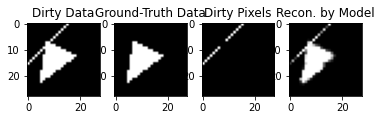

y_noise: 1


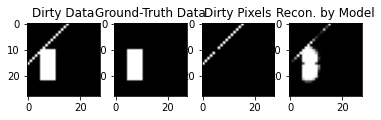

y_noise: 1


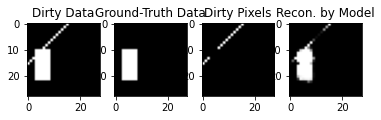

y_noise: 1


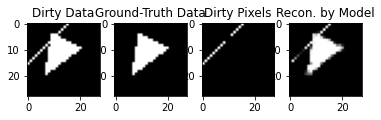

y_noise: 1


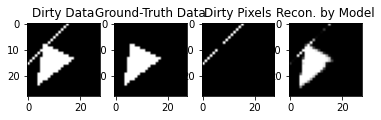

y_noise: 1


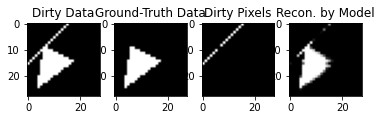

y_noise: 1


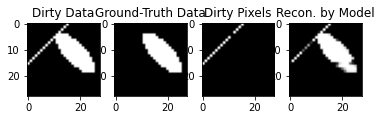

y_noise: 1


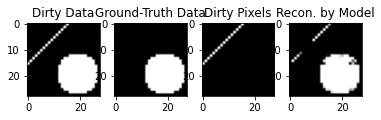

y_noise: 1


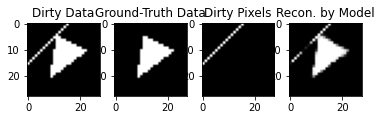

y_noise: 1


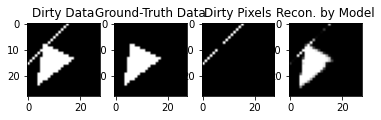

y_noise: 1


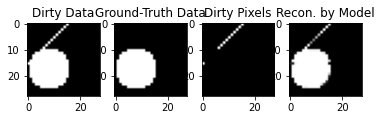

y_noise: 1


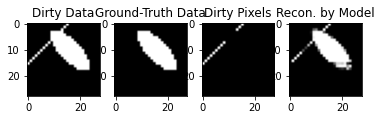

y_noise: 1


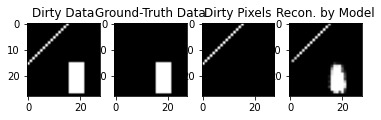

y_noise: 1


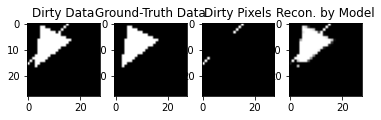

y_noise: 1


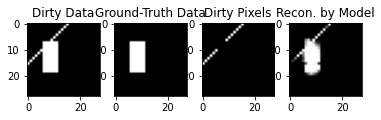

y_noise: 1


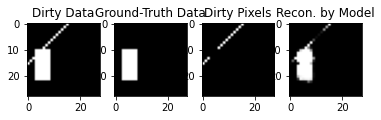

y_noise: 1


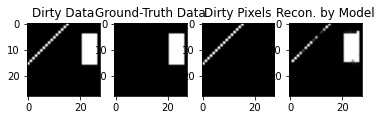

y_noise: 1


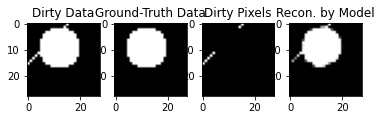

y_noise: 1


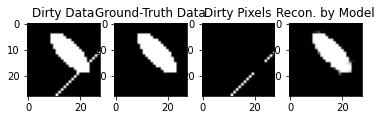

y_noise: 1


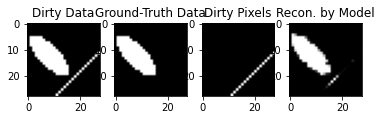

y_noise: 1


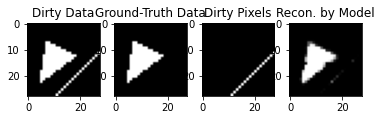

y_noise: 1


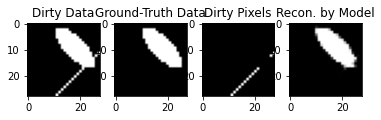

y_noise: 1


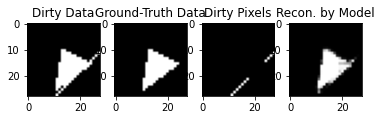

y_noise: 1


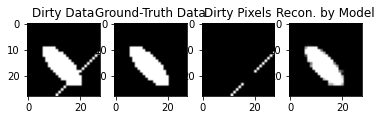

y_noise: 1


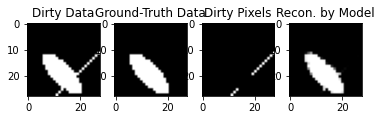

y_noise: 1


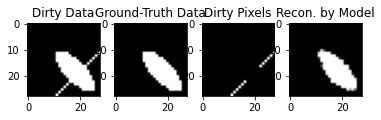

y_noise: 1


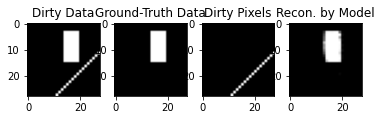

y_noise: 1


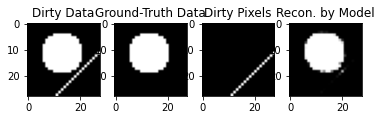

y_noise: 1


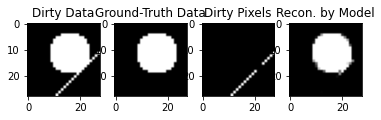

y_noise: 1


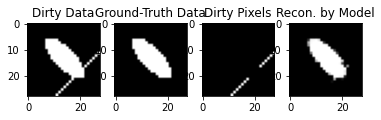

y_noise: 1


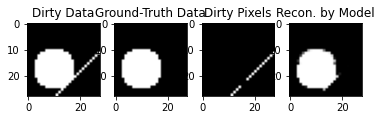

y_noise: 1


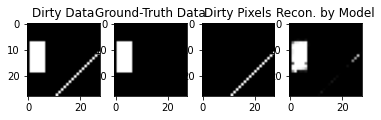

y_noise: 1


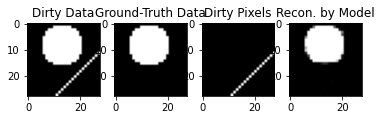

y_noise: 1


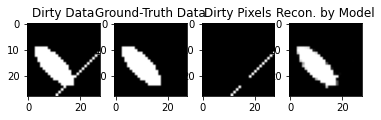

y_noise: 1


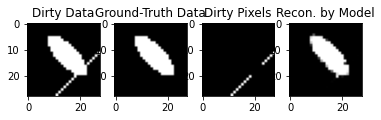

y_noise: 1


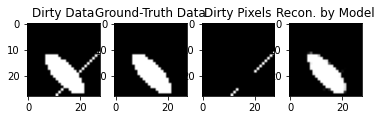

y_noise: 1


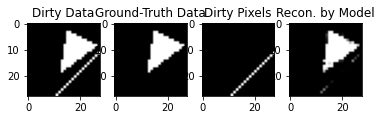

y_noise: 1


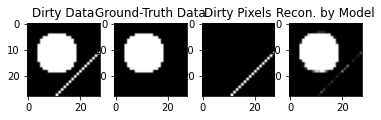

y_noise: 1


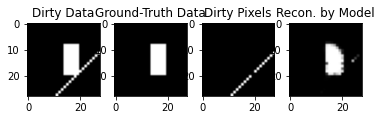

y_noise: 1


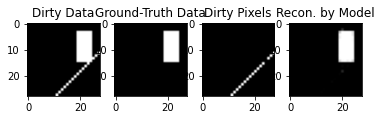

y_noise: 1


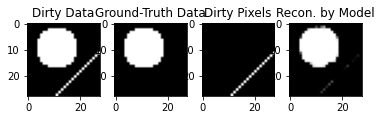

y_noise: 1


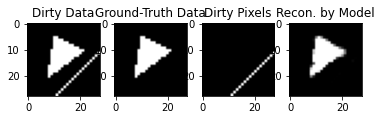

y_noise: 1


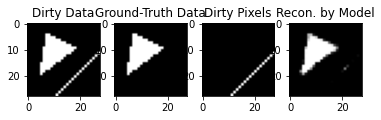

y_noise: 1


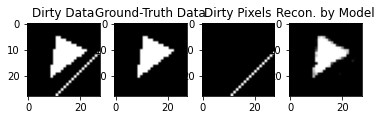

y_noise: 1


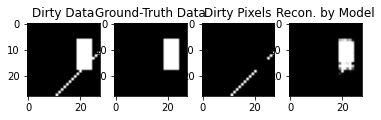

y_noise: 1


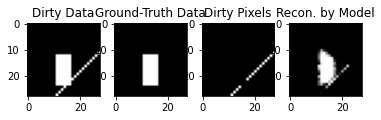

y_noise: 1


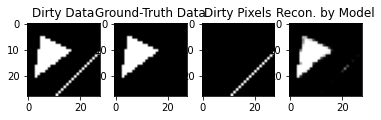

y_noise: 1


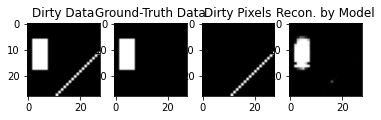

y_noise: 1


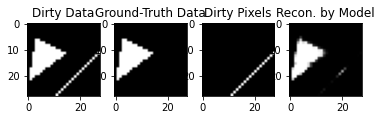

y_noise: 1


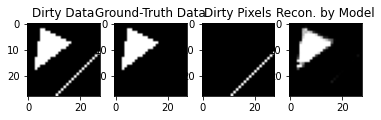

y_noise: 1


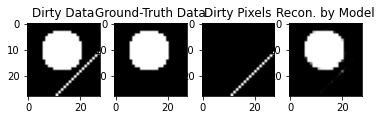

y_noise: 1


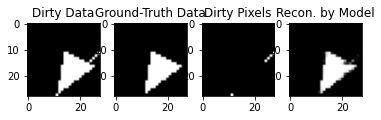

y_noise: 1


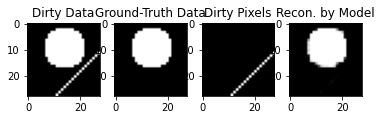

y_noise: 1


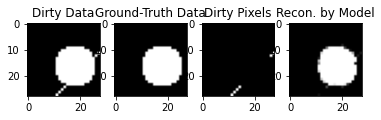

y_noise: 1


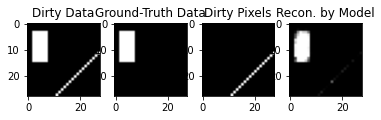

y_noise: 1


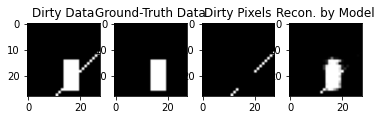

y_noise: 1


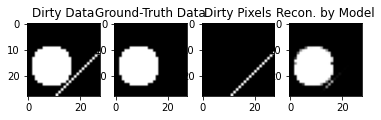

y_noise: 1


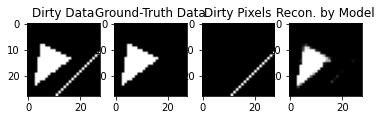

y_noise: 1


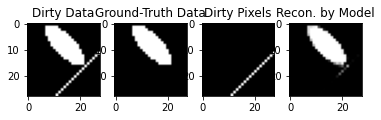

y_noise: 1


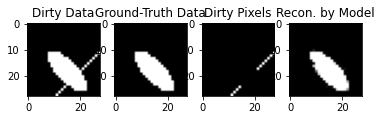

y_noise: 1


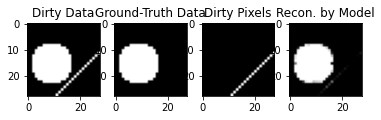

y_noise: 1


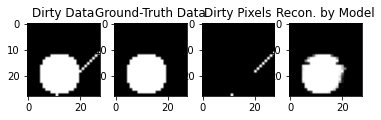

y_noise: 1


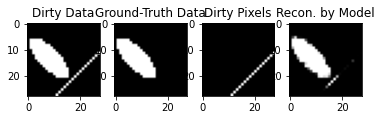

y_noise: 1


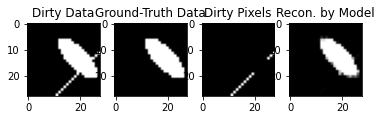

y_noise: 1


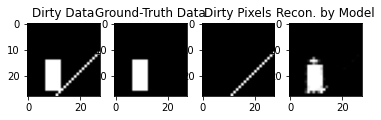

y_noise: 1


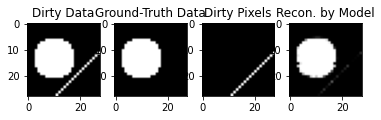

y_noise: 1


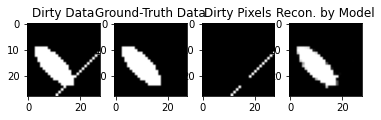

y_noise: 1


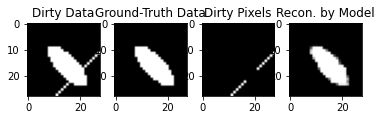

In [43]:
for idx in trusted_idxs_train:
    print("y_noise: {}".format(int(y_noise_instance_train[idx])))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(x_train_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[0].set_title("Dirty Data")
    ax[1].imshow(x_train_clean_orig[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[1].set_title("Ground-Truth Data")
    ax[2].imshow(y_noise_pixels_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[2].set_title("Dirty Pixels")
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray") # , vmin=0.0, vmax=1.0
    ax[3].imshow(recon_imgs_train[idx,...], cmap="gray")
    ax[3].set_title("Recon. by Model")
    plt.show()


### Show Latent Space

In [44]:
noised_rows = y_noise_instance_train
noised_rows_str = ["Inlier" if not row_val else "Outlier" for row_val in noised_rows]

#### PCA

In [45]:
from sklearn.decomposition import PCA

# Use underlying clean train data for representation
pca_2d_z = PCA(n_components=2) # PCA
pca_2d_z.fit(z_train_clean)

PCA(n_components=2)

In [46]:
pca_2d_z.explained_variance_

array([0.55609834, 0.52953017], dtype=float32)

In [47]:
z_train_pca2d_clean = pca_2d_z.transform(z_train_clean)

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

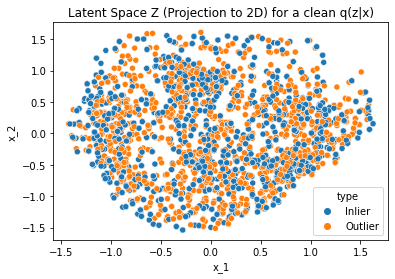

In [48]:
df_plot_z_pca2d_y1 = pd.DataFrame({"x_1": z_train_pca2d_clean[:,0], 
                                   "x_2": z_train_pca2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_pca2d_y1)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

### Kernel PCA

In [49]:
from sklearn.decomposition import KernelPCA

# Use underlying clean train data for representation
kpca_2d_z = KernelPCA(n_components=2, kernel='rbf', degree=5)
kpca_2d_z.fit(z_train_clean)

KernelPCA(degree=5, kernel='rbf', n_components=2)

In [50]:
z_train_kpca2d_clean = kpca_2d_z.transform(z_train_clean)

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

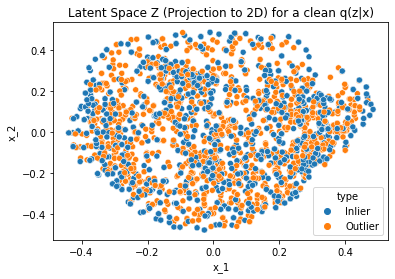

In [51]:
df_plot_z_kpca2d = pd.DataFrame({"x_1": z_train_kpca2d_clean[:,0], 
                                   "x_2": z_train_kpca2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_kpca2d)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

#### T-SNE

In [52]:
from sklearn.manifold import TSNE

In [53]:
tsne_2d_z = TSNE(n_components=2, perplexity=250.0, n_iter=5000)
_z_all_2d = tsne_2d_z.fit_transform(z_train_clean)

In [54]:
_len_dataset = z_train_clean.shape[0]
z_train_tsne2d_clean = _z_all_2d

Text(0.5, 1.0, 'Latent Space Z (Projection to 2D) for a clean q(z|x)')

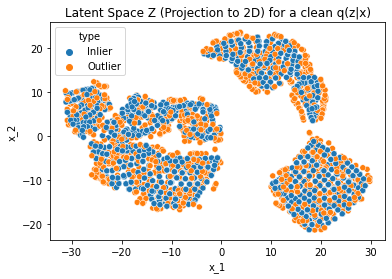

In [55]:
df_plot_z_tsne2d = pd.DataFrame({"x_1": z_train_tsne2d_clean[:,0], 
                                   "x_2": z_train_tsne2d_clean[:,1], 
                                   "type": noised_rows_str})
sns.scatterplot(x="x_1",y="x_2",hue="type",data=df_plot_z_tsne2d)
plt.title("Latent Space Z (Projection to 2D) for a clean q(z|x)")

### Approx. Log-Likelihood -- via IWAE (Importance Weighted AE Loss)

In [56]:
from repair_syserr_models.loss_utils import log_px_approx_eval

In [57]:
# TODO: insert option for cuda vs. cpu !!
x_inputs = X_train.cuda()
vae_mdl.cuda();


In [58]:
with torch.autograd.profiler.profile(use_cuda=True, profile_memory=True) as prof:

    # log p(x|y) evaluation, for both y=1 and y=0
    elbo_iwae = log_px_approx_eval(vae_mdl,
                                   dataset_obj,
                                   x_inputs,
                                   k_samples=250,
                                   y_comps=False,
                                   batch_size=128, 
                                   y_targets=y_targets_mdl.cuda(), 
                                   repair_mode=True)

    # to clear GPU Mem -- if used.
    log_px_est = elbo_iwae.clone().cpu()
    
    del elbo_iwae
    torch.cuda.empty_cache()


Compute Progress: 100%|█████████████████████████████████████████████| 32/32 [00:01<00:00, 29.49it/s]


In [59]:
# print(prof)

In [60]:
arrs_elbo_iwae = np.concatenate([log_px_est, y_noise_instance_train.reshape(-1,1)], axis=1)

df_elbo_iwae = pd.DataFrame(arrs_elbo_iwae, columns=["log_px", "noise_label"])
df_elbo_iwae["noise_label"] = df_elbo_iwae["noise_label"].apply(lambda x: "dirty" if x==1 else "clean")

In [61]:
df_elbo_iwae

log_px noise_label
0     -25.624115       clean
1     -23.798979       clean
2    -222.791397       dirty
3    -131.106216       dirty
4     -24.869257       clean
...          ...         ...
3995  -38.238586       clean
3996  -28.891533       clean
3997  -23.479927       clean
3998  -24.521078       clean
3999  -53.553589       dirty

[4000 rows x 2 columns]

In [62]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)


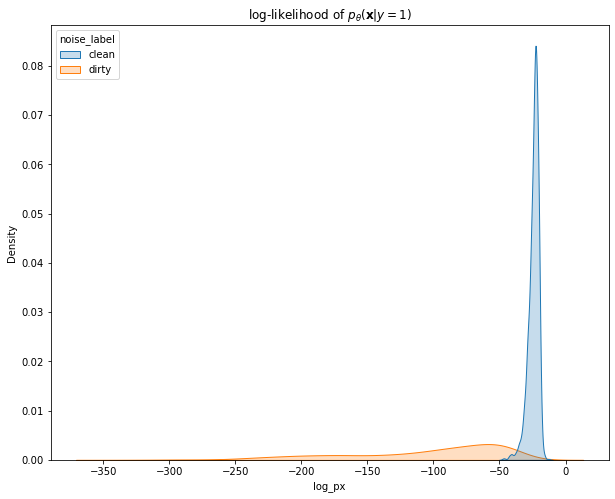

In [63]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

sns.kdeplot(ax=axes, data=df_elbo_iwae, x="log_px", hue="noise_label", fill=True, legend=True)

axes.set_title("log-likelihood of $p_{\\theta}(\mathbf{x}|y=1)$")
move_legend(axes, "upper left")


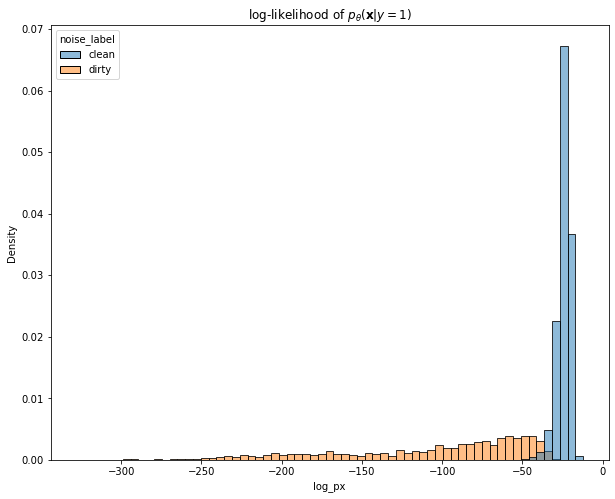

In [64]:
fig, axes = plt.subplots(1,1, figsize=(10,8))

sns.histplot(ax=axes, data=df_elbo_iwae, x="log_px", hue="noise_label", legend=True, stat="density")
axes.set_title("log-likelihood of $p_{\\theta}(\mathbf{x}|y=1)$")
move_legend(axes, "upper left")


In [65]:
def epdf(xs, bins):
    xmin, xmax = np.inf, -np.inf
    for xi in xs:
        xmin = min(xmin, np.nanmin(xi))
        xmax = max(xmax, np.nanmax(xi))
    bin_range = (xmin, xmax)
    bins = np.lib.histograms.histogram_bin_edges(np.concatenate(xs), bins, bin_range)
    tops = []
    for xi in xs:
        m, _ = np.histogram(xi, bins, density=True)
        tops.append(m.astype(float))
    return tops, bins


In [66]:
tops, bin_edges = epdf([log_px_est.numpy().flatten()[~y_noise_instance_train], log_px_est.numpy().flatten()[y_noise_instance_train]], 25)
top_model, top_data = tops[0], tops[1]

In [67]:
# Earth Movers Distance (EMD)
np.sum(np.abs(top_model - top_data))

0.15221616540171817

In [68]:
def histogram_intersection(h1, h2, bins):
    bins = np.diff(bins)
    sm = 0
    for i in range(len(bins)):
        sm += min(bins[i]*h1[i], bins[i]*h2[i])
    return sm

In [69]:
# Area of intersection between the two histograms
histogram_intersection(tops[0], tops[1], bin_edges)

0.03776260850085103